# Finding Voice in Transformational Adaptation for Improved Wastewater Management in Regional Communities: Crime, Mental Health and Emerging Contaminants

## Setting Up the Conda Environment
To recreate the Conda environment used in this project, run:

```bash
conda env create -f onehealth_envionment.yml
conda activate onehealth_envionment


### Importing Packages

In [1]:
import os
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
from functools import reduce
from scipy.stats import pearsonr, f_oneway, shapiro, levene, kruskal, spearmanr, shapiro, zscore
import statsmodels.api as sm
from statsmodels.stats.multicomp import pairwise_tukeyhsd
from statsmodels.stats.oneway import anova_oneway
from scikit_posthocs import posthoc_dunn

## Data Collection and Processing
Cleaning and merging of data

### Data Preprocessing

In [18]:
# Index for LGAs
lga_df = pd.read_csv("Data/2021CensusNSWLGAData/australian_census_2021_local_government_areas.csv")

# Extract unique LGA codes and names, excluding any trailing null/invalid values
lga_codes = lga_df['LGA_CODE_2021'].unique()[:-1]  # Exclude last element which is not a number
lga_names = lga_df['LGA_NAME_2021'].unique()

# Convert codes to integers and filter for NSW (codes < 20000)
nsw_codes = [int(code) for code in lga_codes]
nsw_codes = [code for code in nsw_codes if code < 20000]

# Format codes with 'LGA' prefix
formatted_codes = [f"LGA{code}" for code in nsw_codes]

# Get corresponding names for NSW LGAs
nsw_names = lga_names[:len(formatted_codes)]

# Create and return the index DataFrame
lga_index_health = pd.DataFrame({
    "LGA_CODE_2021": formatted_codes,
    "LGA_NAME_2021": nsw_names})

# Create new DataFrame with cleaned names
lga_index_crime = pd.DataFrame({
    'LGA_CODE_2021': lga_index_health['LGA_CODE_2021'],
    'LGA_NAME_2021': lga_index_health['LGA_NAME_2021'].str.replace(r"\s*\(NSW\)", "", regex=True)})

/tmp/ipykernel_56260/3149445699.py:2: DtypeWarning: Columns (0,1,3) have mixed types. Specify dtype option on import or set low_memory=False.
  lga_df = pd.read_csv("Data/2021CensusNSWLGAData/australian_census_2021_local_government_areas.csv")


#### Crime Data

In [19]:
# Importing the crime data
df_crime = pd.read_csv("Data/nsw_lga_offence_data_by_month_1995_2024.csv", 
                             index_col=[0, 1, 2])
# Filtering for the year 2021
df_crime = df_crime.loc[:, df_crime.columns.str.contains("2021")]

# Replace 'Subcategory' index name 'Offence category' name index name when NaN.
df_crime_modified = df_crime.copy()
df_crime_modified.index = df_crime_modified.index.map(lambda x: (x[0], x[1], x[1] if pd.isna(x[2]) else x[2]))

# Sum the Subcategory crime incidents for 2021
df_crime_modified = df_crime_modified.droplevel("Offence category")
df_crime_modified = df_crime_modified.sum(axis="columns")

# Unstack Subcategory to select crimes of interest as columns
df_crime_modified = df_crime_modified.unstack(level="Subcategory")
df_crime_modified = df_crime_modified[["Domestic violence related assault", 
                               "Non-domestic violence related assault",
                               "Assault Police",
                               "Sexual assault",
                               "Sexual touching, sexual act and other sexual offences", 
                               "Intimidation, stalking and harassment"]]

# Rename the index name for LGA for further processing
df_crime_modified = df_crime_modified.rename(index={"LGA":"LGA_NAME_2021"})
df_crime_modified.index.name = "LGA_NAME_2021"

# Sum the values and create new index entry 'Unincorporated NSW'
df_crime_modified.loc['Unincorporated NSW'] = df_crime_modified.loc['Unincorporated Far West'] + df_crime_modified.loc['Lord Howe Island']

# Drop the old index entries
df_crime_modified = df_crime_modified.drop(['Unincorporated Far West', 'Lord Howe Island'])

# Prepare and Merge the Index with LGA Codes
df_crime_modified.rename(index={'Cootamundra-Gundagai': 'Cootamundra-Gundagai Regional'}, inplace=True)
df_crime_modified = df_crime_modified.merge(lga_index_crime, how='left', on='LGA_NAME_2021')

In [20]:
df_crime_modified

LGA_NAME_2021  Domestic violence related assault  \
0                Albury                                405   
1     Armidale Regional                                237   
2               Ballina                                147   
3             Balranald                                  7   
4     Bathurst Regional                                335   
..                  ...                                ...   
125         Wollondilly                                146   
126          Wollongong                                652   
127           Woollahra                                102   
128         Yass Valley                                 36   
129  Unincorporated NSW                                 19   

     Non-domestic violence related assault  Assault Police  Sexual assault  \
0                                      340              41              75   
1                                      200               6              75   
2                                      126               9              61   
3                                        6               0               0   
4                                      281              24              77   
..                                     ...             ...             ...   
125                                     82               5              38   
126                                    708              82             188   
127                                     98               6              53   
128                                     29               2              11   
129                                      4               0              11   

     Sexual touching, sexual act and other sexual offences  \
0                                                   79       
1                                                   54       
2                                                   42       
3                                                    1       
4                                                   87       
..                                                 ...       
125                                                 46       
126                                                196       
127                                                 35       
128                                                  6       
129                                                 18       

     Intimidation, stalking and harassment LGA_CODE_2021  
0                                      516      LGA10050  
1                                      219      LGA10180  
2                                      144      LGA10250  
3                                        6      LGA10300  
4                                      426      LGA10470  
..                                     ...           ...  
125                                    196      LGA18400  
126                                    782      LGA18450  
127                                    138      LGA18500  
128                                     45      LGA18710  
129                                     15      LGA19399  

[130 rows x 8 columns]

#### Population and Health Data

In [21]:
# Importing the census data on health and the LGA names
census_04a_df = pd.read_csv("Data/2021CensusNSWLGAData/2021 Census GCP Local Government Areas for NSW/2021Census_G04A_NSW_LGA.csv")
census_04b_df = pd.read_csv("Data/2021CensusNSWLGAData/2021 Census GCP Local Government Areas for NSW/2021Census_G04B_NSW_LGA.csv")
census_19a_df = pd.read_csv("Data/2021CensusNSWLGAData/2021 Census GCP Local Government Areas for NSW/2021Census_G19A_NSW_LGA.csv")
census_19b_df = pd.read_csv("Data/2021CensusNSWLGAData/2021 Census GCP Local Government Areas for NSW/2021Census_G19B_NSW_LGA.csv")
#census_19c_df = pd.read_csv("MaterialsAndMethods/Data/2021CensusNSWLGAData/NSWLGACensus2021HealthData/2021Census_G19C_NSW_LGA.csv")

In [22]:
# Merge the census data on the LGA_CODE_2021
data_frames = [census_04a_df, census_04b_df, census_19a_df, census_19b_df]
census_nsw_pop_health = reduce(lambda  left,right: pd.merge(left,right,on=['LGA_CODE_2021'],
                                            how='outer'), data_frames)

In [23]:
# Creating the population groups for assessment
male_young_pop = [f"Age_yr_{i}_{i+4}_M" for i in range(0, 35, 5)]
male_older_pop = [f"Age_yr_{i}_{i+4}_M" for i in range(35, 100, 5)] + ["Age_yr_100_yr_over_M"]
female_young_pop = [f"Age_yr_{i}_{i+4}_F" for i in range(0, 35, 5)]
female_older_pop = [f"Age_yr_{i}_{i+4}_F" for i in range(35, 100, 5)] + ["Age_yr_100_yr_over_F"]

# Creating the mental health age groups for assessment
male_young_mh = ['M_Mental_health_cond_0_14', 'M_Mental_health_cond_15_24', 'M_Mental_health_cond_25_34']
male_older_mh = ['M_Mental_health_cond_35_44',	'M_Mental_health_cond_45_54',	'M_Mental_health_cond_55_64',	'M_Mental_health_cond_65_74',	'M_Mental_health_cond_75_84',	'M_Mental_health_cond_85_over']
female_young_mh = ['F_Mental_health_cond_0_14', 'F_Mental_health_cond_15_24', 'F_Mental_health_cond_25_34']
female_older_mh = ['F_Mental_health_cond_35_44',	'F_Mental_health_cond_45_54',	'F_Mental_health_cond_55_64',	'F_Mental_health_cond_65_74',	'F_Mental_health_cond_75_84',	'F_Mental_health_cond_85_over']

In [24]:
# Create the new summed population categories
census_nsw_pop_health['M_total_pop_0_34'] = census_nsw_pop_health[male_young_pop].sum(axis=1)
census_nsw_pop_health['M_total_pop_35_85_over'] = census_nsw_pop_health[male_older_pop].sum(axis=1)
census_nsw_pop_health['F_total_pop_0_34'] = census_nsw_pop_health[female_young_pop].sum(axis=1)
census_nsw_pop_health['F_total_pop_35_85_over'] = census_nsw_pop_health[female_older_pop].sum(axis=1)

# Create the new summed mental health categories
census_nsw_pop_health['M_Mental_health_cond_0_34'] = census_nsw_pop_health[male_young_mh].sum(axis=1)
census_nsw_pop_health['M_Mental_health_cond_35_85_over'] = census_nsw_pop_health[male_older_mh].sum(axis=1)
census_nsw_pop_health['F_Mental_health_cond_0_34'] = census_nsw_pop_health[female_young_mh].sum(axis=1)
census_nsw_pop_health['F_Mental_health_cond_35_85_over'] = census_nsw_pop_health[female_older_mh].sum(axis=1)

# Filter for the categories of interest
census_nsw_pop_health = census_nsw_pop_health.loc[:, ['Tot_P', 
                                                      'M_Mental_health_cond_0_34',
                                                      'M_Mental_health_cond_35_85_over', 
                                                      'F_Mental_health_cond_0_34', 
                                                      'F_Mental_health_cond_35_85_over',
                                                      'M_total_pop_0_34',
                                                      'M_total_pop_35_85_over',
                                                      'F_total_pop_0_34',
                                                      'F_total_pop_35_85_over',
                                                      'LGA_CODE_2021']]

In [25]:
# Since the census data only has the code merge with the LGA code
census_nsw_pop_health = census_nsw_pop_health.merge(lga_index_health, how='left', on='LGA_CODE_2021')

#### Preparing Crime and Mental Health Rates

In [26]:
# Merging the Census Data with the Crime Data
df_crime_health = df_crime_modified.merge(census_nsw_pop_health, on="LGA_CODE_2021")
df_crime_health = df_crime_health.drop(labels=['LGA_NAME_2021_x'], axis=1)
df_crime_health = df_crime_health.rename(columns={"LGA_NAME_2021_y":"LGA_NAME_2021"})
df_crime_health = df_crime_health.set_index(["LGA_NAME_2021", "LGA_CODE_2021"])

In [27]:
# Calculating the crime rates
df_crime_rates = df_crime_health[["Domestic violence related assault", 
                               "Non-domestic violence related assault",
                               "Assault Police",
                               "Sexual assault",
                               "Sexual touching, sexual act and other sexual offences", 
                               "Intimidation, stalking and harassment"]].div(df_crime_health['Tot_P'], axis=0)

In [28]:
# Calculating the mental health rates
rate_columns = {
    'M_Mental_health_rate_0_34': 'M_Mental_health_cond_0_34',
    'M_Mental_health_rate_35_85_over': 'M_Mental_health_cond_35_85_over',
    'F_Mental_health_rate_0_34': 'F_Mental_health_cond_0_34',
    'F_Mental_health_rate_35_85_over': 'F_Mental_health_cond_35_85_over'}


df_health_rates = pd.DataFrame()

for rate_col, cond_col in rate_columns.items():
    total_pop_col = cond_col.replace('Mental_health_cond', 'total_pop')
    df_health_rates[rate_col] = df_crime_health[cond_col] / df_crime_health[total_pop_col]

In [29]:
df_crime_health_rates = df_health_rates.merge(df_crime_rates, left_index=True, right_index=True)
df_crime_health_rates

M_Mental_health_rate_0_34  \
LGA_NAME_2021      LGA_CODE_2021                              
Albury             LGA10050                        0.071983   
Armidale Regional  LGA10180                        0.065987   
Ballina            LGA10250                        0.067368   
Balranald          LGA10300                        0.024691   
Bathurst Regional  LGA10470                        0.075743   
...                                                     ...   
Wollondilly        LGA18400                        0.051840   
Wollongong         LGA18450                        0.063506   
Woollahra          LGA18500                        0.036816   
Yass Valley        LGA18710                        0.062856   
Unincorporated NSW LGA19399                        0.050000   

                                  M_Mental_health_rate_35_85_over  \
LGA_NAME_2021      LGA_CODE_2021                                    
Albury             LGA10050                              0.109088   
Armidale Regional  LGA10180                              0.083152   
Ballina            LGA10250                              0.094947   
Balranald          LGA10300                              0.044515   
Bathurst Regional  LGA10470                              0.094778   
...                                                           ...   
Wollondilly        LGA18400                              0.074279   
Wollongong         LGA18450                              0.088954   
Woollahra          LGA18500                              0.048311   
Yass Valley        LGA18710                              0.090454   
Unincorporated NSW LGA19399                              0.085714   

                                  F_Mental_health_rate_0_34  \
LGA_NAME_2021      LGA_CODE_2021                              
Albury             LGA10050                        0.130851   
Armidale Regional  LGA10180                        0.115792   
Ballina            LGA10250                        0.105814   
Balranald          LGA10300                        0.055556   
Bathurst Regional  LGA10470                        0.123931   
...                                                     ...   
Wollondilly        LGA18400                        0.089595   
Wollongong         LGA18450                        0.118190   
Woollahra          LGA18500                        0.074161   
Yass Valley        LGA18710                        0.110038   
Unincorporated NSW LGA19399                        0.059459   

                                  F_Mental_health_rate_35_85_over  \
LGA_NAME_2021      LGA_CODE_2021                                    
Albury             LGA10050                              0.143902   
Armidale Regional  LGA10180                              0.115668   
Ballina            LGA10250                              0.119538   
Balranald          LGA10300                              0.050691   
Bathurst Regional  LGA10470                              0.139516   
...                                                           ...   
Wollondilly        LGA18400                              0.110521   
Wollongong         LGA18450                              0.129863   
Woollahra          LGA18500                              0.059787   
Yass Valley        LGA18710                              0.124953   
Unincorporated NSW LGA19399                              0.031447   

                                  Domestic violence related assault  \
LGA_NAME_2021      LGA_CODE_2021                                      
Albury             LGA10050                                0.007220   
Armidale Regional  LGA10180                                0.008138   
Ballina            LGA10250                                0.003175   
Balranald          LGA10300                                0.003170   
Bathurst Regional  LGA10470                                0.007689   
...                                                             ...   
Wollondilly        LGA18400   

####  Preparing Census Indexes & Council Classification

In [30]:
cols_interest = ["Index of Relative Socio-economic Disadvantage Score", 
                 "Index of Relative Socio-economic Advantage and Disadvantage Score", 
                 "Index of Economic Resources Score",
                 "Index of Education and Occupation Score"]

seifa_df = pd.read_csv("Data/250110_local_government_areas_indexes_seifa_2021_nsw.csv",
                       skiprows=5,
                       index_col=["LGA_CODE_2021","LGA_NAME_2021"])

In [31]:
# Return the indexes of interest.
seifa_df = seifa_df[cols_interest]
df_crime_health_seifa = seifa_df.merge(df_crime_health_rates, on="LGA_NAME_2021")

In [32]:
council_type_df = pd.read_csv("Data/250110_nsw_councils_group_and_type.csv",
                       index_col=["LGA_NAME_2021"])

In [33]:
# Evaluate the Difference in Index for Primary Dataset 
crime_health_seifa_index = df_crime_health_seifa.index
council_type_index = council_type_df.index
only_in_crime_health_seifa_index = crime_health_seifa_index.difference(council_type_index)
print("Only in Crime Health Seifa Index:", only_in_crime_health_seifa_index)

Only in Crime Health Seifa Index: Index(['Unincorporated NSW'], dtype='object', name='LGA_NAME_2021')


In [34]:
# Merge and export the merged dataframes
df_crime_health_seifa_council = df_crime_health_seifa.merge(council_type_df, on="LGA_NAME_2021")
df_crime_health_seifa_council.to_csv("250110_crime_health_seifa_council_data.csv")

In [35]:
# Rename the columns for better readability
df_crime_health_seifa_council = df_crime_health_seifa_council.rename(columns={
    'Index of Relative Socio-economic Disadvantage Score': 'Socio-economic Disadvantage',
    'Index of Relative Socio-economic Advantage and Disadvantage Score': 'Socio-economic Advantage/Disadvantage',
    'Index of Economic Resources Score': 'Economic Resources',
    'Index of Education and Occupation Score': 'Education and Occupation',
    'M_Mental_health_rate_0_34': 'Male Mental Health Rate (0-34)',
    'M_Mental_health_rate_35_85_over': 'Male Mental Health Rate (>35)',
    'F_Mental_health_rate_0_34': 'Female Mental Health Rate (0-34)',
    'F_Mental_health_rate_35_85_over': 'Female Mental Health Rate (>35)',
    'Domestic violence related assault': 'Domestic Violence Assault',
    'Non-domestic violence related assault': 'Non-domestic Violence Assault',
    'Assault Police': 'Assault on Police',
    'Sexual assault': 'Sexual Assault',
    'Sexual touching, sexual act and other sexual offences': 'Sexual Offences',
    'Intimidation, stalking and harassment': 'Stalking and Harassment'})
df_crime_health_seifa_council.head(10)

Socio-economic Disadvantage  \
LGA_NAME_2021                                    
Albury                                     968   
Armidale Regional                          980   
Ballina                                   1015   
Balranald                                  960   
Bathurst Regional                          991   
Bayside (NSW)                             1004   
Bega Valley                                986   
Bellingen                                  981   
Berrigan                                   966   
Blacktown                                  987   

                   Socio-economic Advantage/Disadvantage  Economic Resources  \
LGA_NAME_2021                                                                  
Albury                                               950                 962   
Armidale Regional                                    976                 955   
Ballina                                              996                1011   
Balranald                                            934                 970   
Bathurst Regional                                    967                 999   
Bayside (NSW)                                       1044                 966   
Bega Valley                                          949                 987   
Bellingen                                            960                 983   
Berrigan                                             927                 974   
Blacktown                                           1006                1020   

                   Education and Occupation  Male Mental Health Rate (0-34)  \
LGA_NAME_2021                                                                 
Albury                                  954                        0.071983   
Armidale Regional                      1010                        0.065987   
Ballina                                 991                        0.067368   
Balranald                               915                        0.024691   
Bathurst Regional                       959                        0.075743   
Bayside (NSW)                          1051                        0.028677   
Bega Valley                             946                        0.067494   
Bellingen                               985                        0.065884   
Berrigan                                913                        0.061429   
Blacktown                               993                        0.037010   

                   Male Mental Health Rate (>35)  \
LGA_NAME_2021                                      
Albury                                  0.109088   
Armidale Regional                       0.083152   
Ballina                                 0.094947   
Balranald                               0.044515   
Bathurst Regional                       0.094778   
Bayside (NSW)                           0.055065   
Bega Valley                             0.093239   
Bellingen                               0.090952   
Berrigan                                0.093370   
Blacktown                               0.057632   

                   Female Mental Health Rate (0-34)  \
LGA_NAME_2021                                         
Albury                                     0.130851   
Armidale Regional                          0.115792   
Ballina                                    0.105814   
Balranald                                  0.055556   
Bathurst Regional                          0.123931   
Bayside (NSW)                              0.050046   
Bega Valley                                0.108700   
Bellingen                                  0.106343   
Berrigan                                   0.091938   
Blacktown                                  0.058605   

                   Female Mental Health Rate (>35)  Domestic Violence Assault  \
LGA_NAME_2021                                                                   
Albury                                    0.143902          

In [36]:
# For individual council type analysis, for example
# df_crime_health_seifa_council = df_crime_health_seifa_council[df_crime_health_seifa_council['Council Type']=='Metropolitan Fringe']

## Exploratory Data Analysis (EDA)
* Summary statistics for key variables.
* Visualization of relationships (e.g. scatter plots, histograms, correlation matricies). 
* Insights from initial exploration

1. **Summary Statistics**
2. **Boxplots**
3. **Barcharts**
4. **Scatterplots**

#### Summary Statistics

In [24]:
# Summary statistics based on 'Council Type'
summary_by_council_type = df_crime_health_seifa_council.groupby('Council Type').describe()

# Export the results
summary_by_council_type.to_csv('250206_rates_of_mental_health_crime_and_seifa_by_council_type.csv')

# Display the results
summary_by_council_type

Socio-economic Disadvantage                          \
                                          count         mean        std   
Council Type                                                              
Large Rural                                42.0   961.023810  34.493893   
Metropolitan                               25.0  1032.760000  76.428223   
Metropolitan Fringe                         9.0  1030.222222  47.063196   
Regional Town/City                         37.0   982.567568  36.257980   
Rural                                      15.0   941.133333  54.821615   

                                                              \
                       min      25%     50%      75%     max   
Council Type                                                   
Large Rural          888.0   934.75   961.0   977.25  1065.0   
Metropolitan         814.0  1004.00  1057.0  1092.00  1110.0   
Metropolitan Fringe  947.0   994.00  1041.0  1048.00  1098.0   
Regional Town/City   903.0   968.00   985.0   998.00  1070.0   
Rural                818.0   938.50   961.0   974.50   992.0   

                    Socio-economic Advantage/Disadvantage               ...  \
                                                    count         mean  ...   
Council Type                                                            ...   
Large Rural                                          42.0   936.785714  ...   
Metropolitan                                         25.0  1085.920000  ...   
Metropolitan Fringe                                   9.0  1031.444444  ...   
Regional Town/City                                   37.0   961.081081  ...   
Rural                                                15.0   931.466667  ...   

                    Stalking and Harassment           OLG Group             \
                                        75%       max     count       mean   
Council Type                                                                 
Large Rural                        0.011243  0.030840      42.0  10.452381   
Metropolitan                       0.003981  0.006885      25.0   2.680000   
Metropolitan Fringe                0.005625  0.006763       9.0   6.777778   
Regional Town/City                 0.008622  0.016830      37.0   4.297297   
Rural                              0.022217  0.067109      15.0   8.933333   

                                                             
                          std   min   25%   50%   75%   max  
Council Type                                                 
Large Rural          0.503761  10.0  10.0  10.0  11.0  11.0  
Metropolitan         0.556776   1.0   2.0   3.0   3.0   3.0  
Metropolitan Fringe  0.440959   6.0   7.0   7.0   7.0   7.0  
Regional Town/City   0.463373   4.0   4.0   4.0   5.0   5.0  
Rural                0.258199   8.0   9.0   9.0   9.0   9.0  

[5 rows x 120 columns]

#### Boxplots

In [37]:
# Data Preparation

# Define the columns to plot
indexes = ['Economic Resources', 
           'Education and Occupation',
           'Council Type']

mental_health = ['Male Mental Health Rate (0-34)', 
                 'Male Mental Health Rate (>35)', 
                 'Female Mental Health Rate (0-34)', 
                 'Female Mental Health Rate (>35)',
                 'Council Type']

violent_crime = ['Domestic Violence Assault', 
                 'Non-domestic Violence Assault', 
                 'Sexual Assault', 'Sexual Offences', 
                 'Stalking and Harassment',
                 'Council Type']

# Melt the dataframe for the selected columns
df_indexes_melted = df_crime_health_seifa_council[indexes].reset_index().melt(id_vars=["LGA_NAME_2021",
                                                                                       "Council Type"], 
                                                                                       var_name="Index Type", 
                                                                                       value_name="Index Value")

df_mental_health_melted = df_crime_health_seifa_council[mental_health].reset_index().melt(id_vars=["LGA_NAME_2021",
                                                                                       "Council Type"], 
                                                                                       var_name="Mental Health Group", 
                                                                                       value_name="Mental Health Rate")

df_violent_crime_melted = df_crime_health_seifa_council[violent_crime].reset_index().melt(id_vars=["LGA_NAME_2021",
                                                                                       "Council Type"], 
                                                                                       var_name="Crime Type", 
                                                                                       value_name="Crime Rate")

# Convert rates to percentages
df_mental_health_melted["Mental Health Rate"] = df_mental_health_melted["Mental Health Rate"] * 100
df_violent_crime_melted["Crime Rate"] = df_violent_crime_melted["Crime Rate"] * 100

In [38]:
df_mental_health_melted

LGA_NAME_2021         Council Type              Mental Health Group  \
0               Albury   Regional Town/City   Male Mental Health Rate (0-34)   
1    Armidale Regional   Regional Town/City   Male Mental Health Rate (0-34)   
2              Ballina   Regional Town/City   Male Mental Health Rate (0-34)   
3            Balranald                Rural   Male Mental Health Rate (0-34)   
4    Bathurst Regional   Regional Town/City   Male Mental Health Rate (0-34)   
..                 ...                  ...                              ...   
507      Wingecarribee   Regional Town/City  Female Mental Health Rate (>35)   
508        Wollondilly  Metropolitan Fringe  Female Mental Health Rate (>35)   
509         Wollongong   Regional Town/City  Female Mental Health Rate (>35)   
510          Woollahra         Metropolitan  Female Mental Health Rate (>35)   
511        Yass Valley          Large Rural  Female Mental Health Rate (>35)   

     Mental Health Rate  
0              7.198318  
1              6.598680  
2              6.736765  
3              2.469136  
4              7.574267  
..                  ...  
507           10.608907  
508           11.052058  
509           12.986284  
510            5.978740  
511           12.495331  

[512 rows x 4 columns]

Text(0, 0.5, 'Mental Rate (%)')

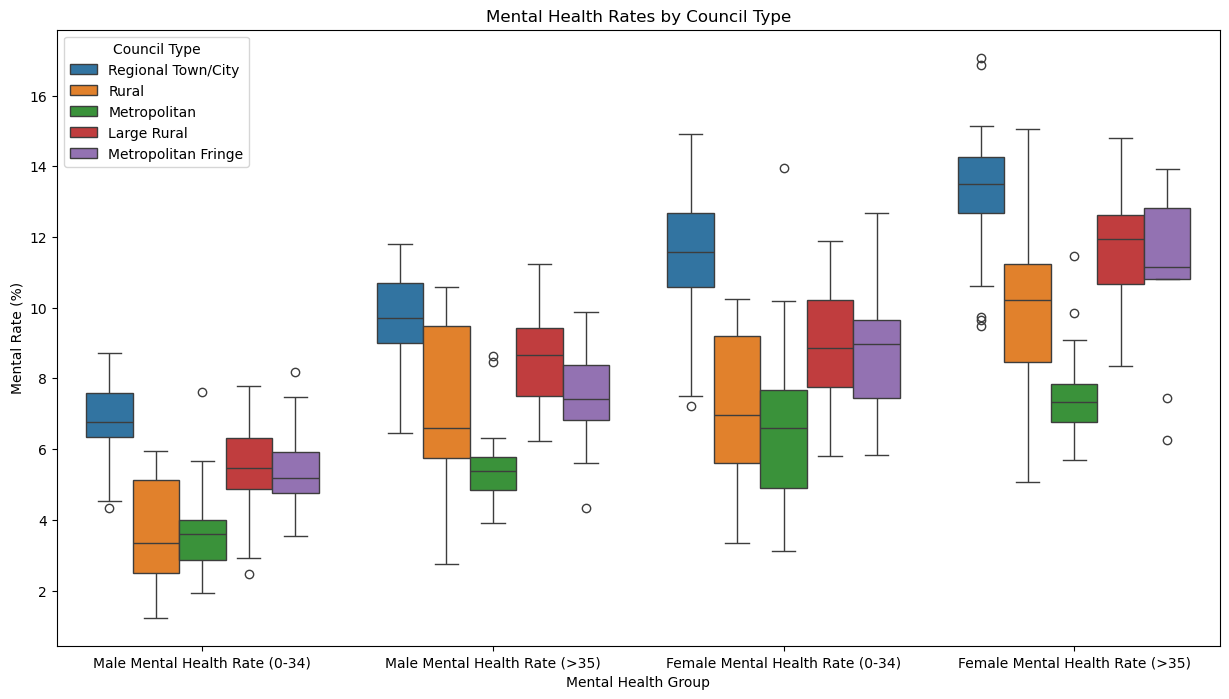

In [39]:
# Create and set the figure size 
fig, ax = plt.subplots(figsize=(15, 8))
# Plot for mental health
sns.boxplot(data=df_mental_health_melted,
            x="Mental Health Group",
            y="Mental Health Rate",
            hue="Council Type",
            ax=ax)

# Customize the plot
ax.set_title('Mental Health Rates by Council Type')
ax.set_ylabel('Mental Rate (%)')

Text(0, 0.5, 'Crime Rate (%)')

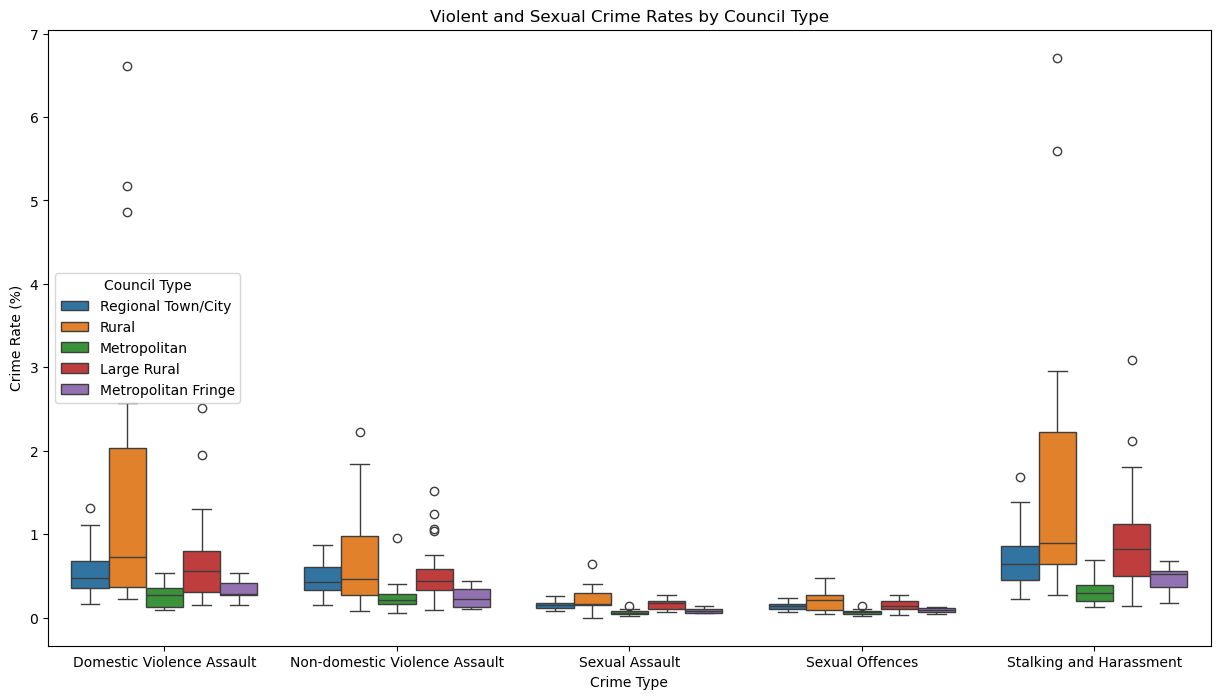

In [40]:
# Create and set the figure size 
fig, ax = plt.subplots(figsize=(15, 8))
# Plot for mental health
sns.boxplot(data=df_violent_crime_melted,
            x="Crime Type",
            y="Crime Rate",
            hue="Council Type",
            ax=ax)

# Customize the plot
ax.set_title('Violent and Sexual Crime Rates by Council Type')
ax.set_ylabel('Crime Rate (%)')

Text(0.5, 1.0, 'Socio-Demographic Indexes by Council Type')

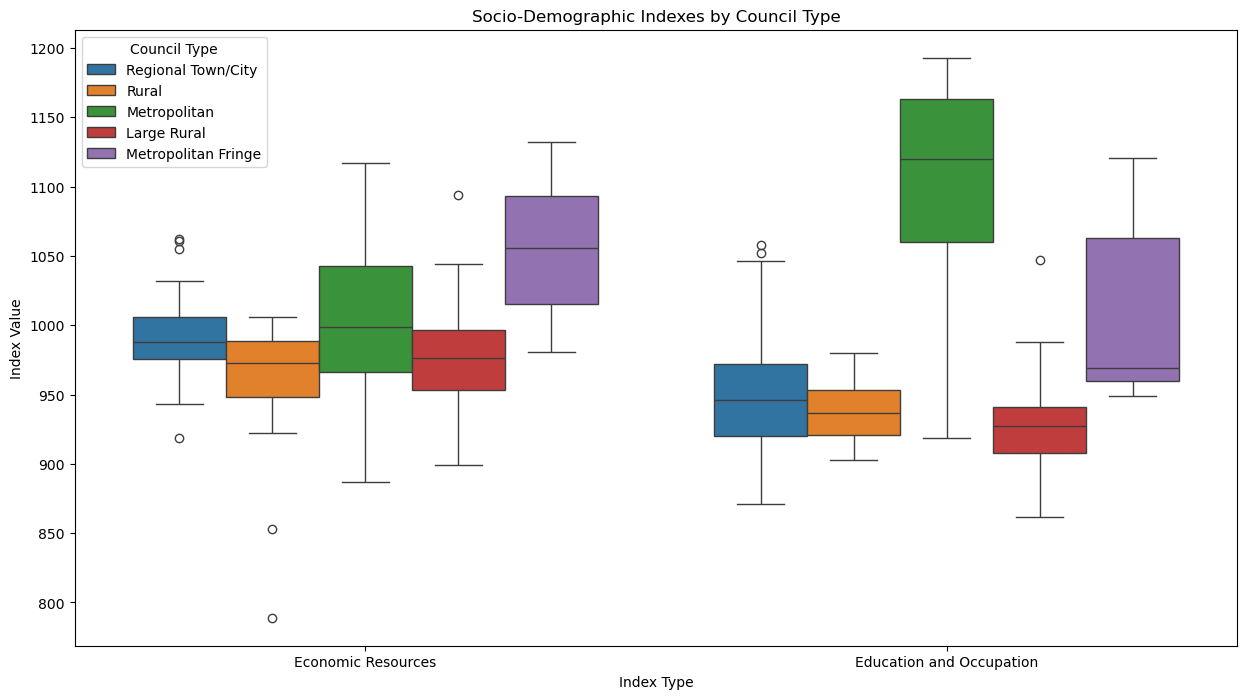

In [41]:
# Create and set the figure size 
fig, ax = plt.subplots(figsize=(15, 8))
# Plot for mental health
sns.boxplot(data=df_indexes_melted,
            x="Index Type",
            y="Index Value",
            hue="Council Type",
            ax=ax)

# Customize the plot
ax.set_title('Socio-Demographic Indexes by Council Type')

#### Barcharts

Text(0, 0.5, 'Mental Health Rate (%)')

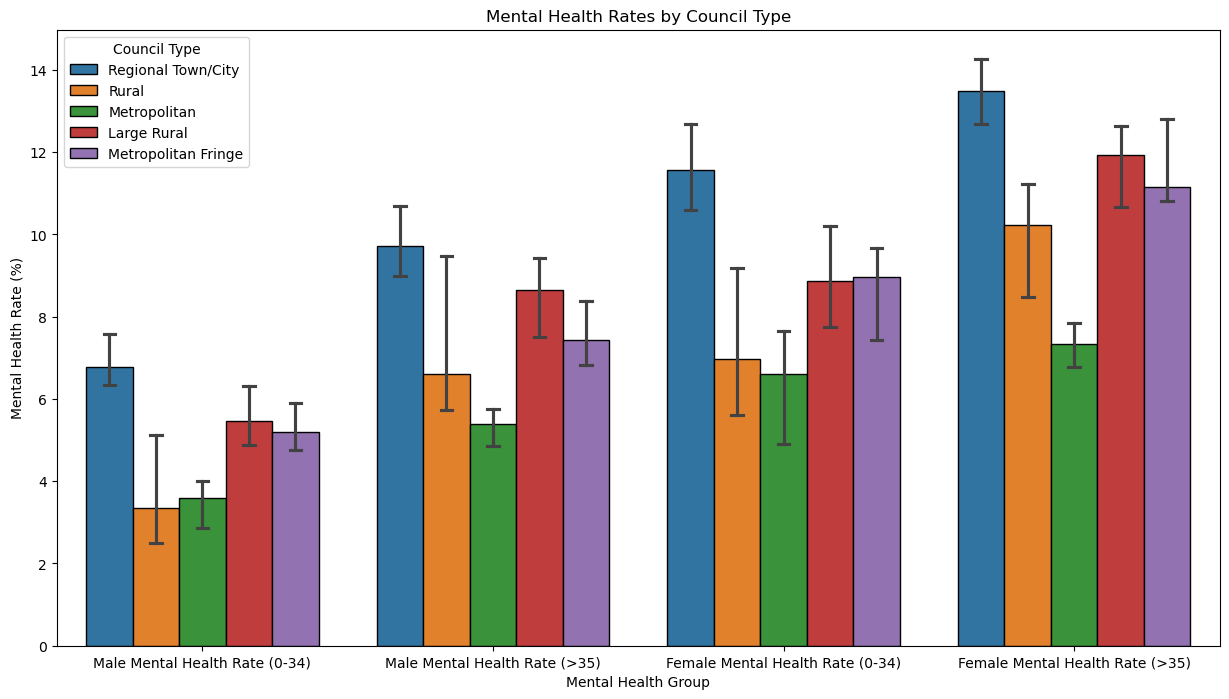

In [42]:
# Create and set the figure size 
fig, ax = plt.subplots(figsize=(15, 8))
# Plot for mental health for median
sns.barplot(data=df_mental_health_melted,
            x="Mental Health Group",
            y="Mental Health Rate",
            hue="Council Type",
            estimator=np.median,
            errorbar=("pi", 50),
            edgecolor="black",
            capsize=0.2,
            ax=ax)

# Customize the plot
ax.set_title('Mental Health Rates by Council Type')
ax.set_ylabel('Mental Health Rate (%)')

Text(0, 0.5, 'Crime Rate (%)')

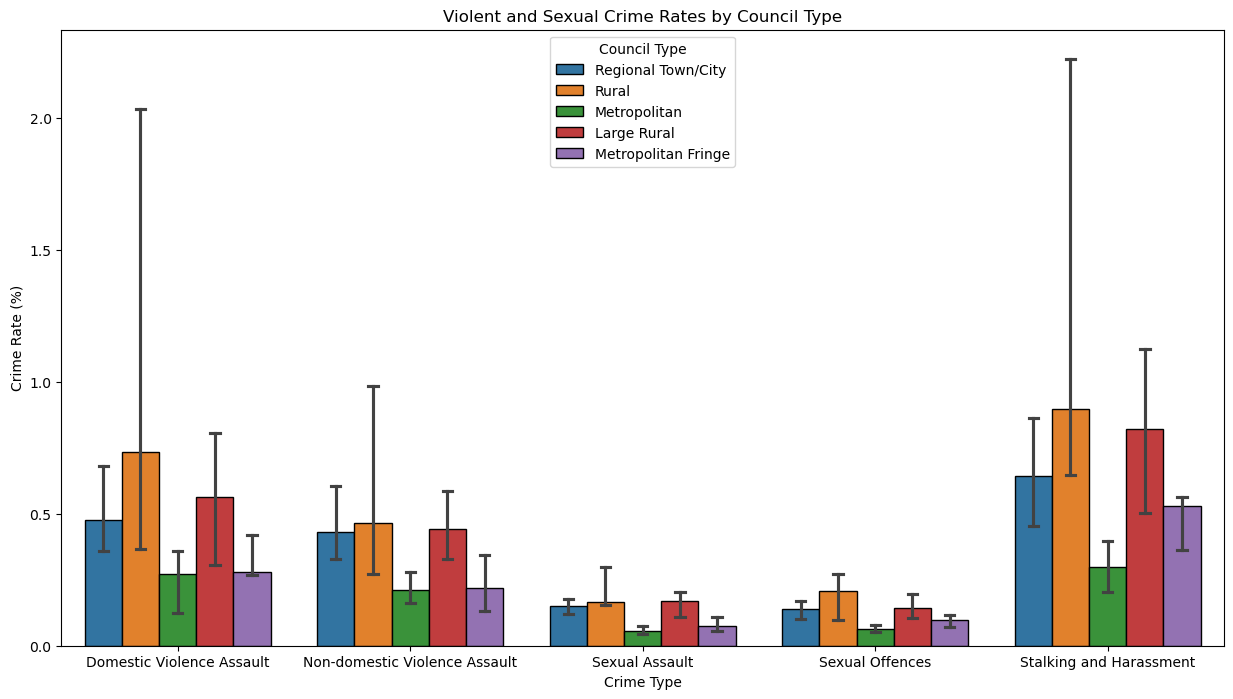

In [43]:
# Create and set the figure size 
fig, ax = plt.subplots(figsize=(15, 8))
# Plot for violent crime for median
sns.barplot(data=df_violent_crime_melted,
            x="Crime Type",
            y="Crime Rate",
            hue="Council Type",
            estimator=np.median,
            errorbar=("pi", 50),
            edgecolor="black",
            capsize=0.2,
            ax=ax)


# Customize the plot
ax.set_title('Violent and Sexual Crime Rates by Council Type')
ax.set_ylabel('Crime Rate (%)')

Text(0.5, 1.0, 'Socio-Demographic Indexes by Council Type')

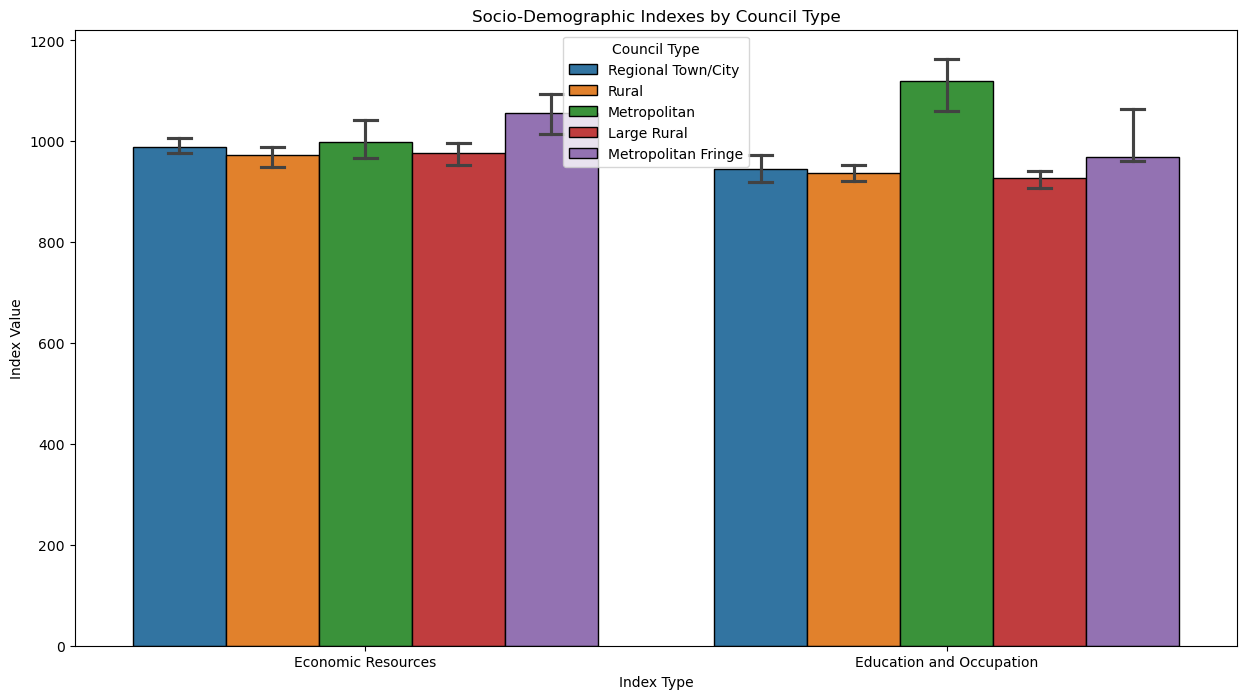

In [44]:
# Create and set the figure size 
fig, ax = plt.subplots(figsize=(15, 8))
# Plot for socio-demographic indexes for medians
sns.barplot(data=df_indexes_melted,
            x="Index Type",
            y="Index Value",
            hue="Council Type",
            estimator=np.median,
            errorbar=("pi", 50),
            edgecolor="black",
            capsize=0.2,
            ax=ax)

# Customize the plot
ax.set_title('Socio-Demographic Indexes by Council Type')

#### Scatterplots

In [ ]:
# Rename the columns for better readability
df_crime_health_seifa_council = df_crime_health_seifa_council.rename(columns={
    'Index of Relative Socio-economic Disadvantage Score': 'Socio-economic Disadvantage',
    'Index of Relative Socio-economic Advantage and Disadvantage Score': 'Socio-economic Advantage/Disadvantage',
    'Index of Economic Resources Score': 'Economic Resources',
    'Index of Education and Occupation Score': 'Education and Occupation',
    'M_Mental_health_rate_0_34': 'Male Mental Health Rate (0-34)',
    'M_Mental_health_rate_35_85_over': 'Male Mental Health Rate (>35)',
    'F_Mental_health_rate_0_34': 'Female Mental Health Rate (0-34)',
    'F_Mental_health_rate_35_85_over': 'Female Mental Health Rate (>35)',
    'Domestic violence related assault': 'Domestic Violence Assault',
    'Non-domestic violence related assault': 'Non-domestic Violence Assault',
    'Assault Police': 'Assault on Police',
    'Sexual assault': 'Sexual Assault',
    'Sexual touching, sexual act and other sexual offences': 'Sexual Offences',
    'Intimidation, stalking and harassment': 'Stalking and Harassment'})
df_crime_health_seifa_council.head(10)


Analyzing correlation for Socio-economic Disadvantage and Socio-economic Advantage/Disadvantage


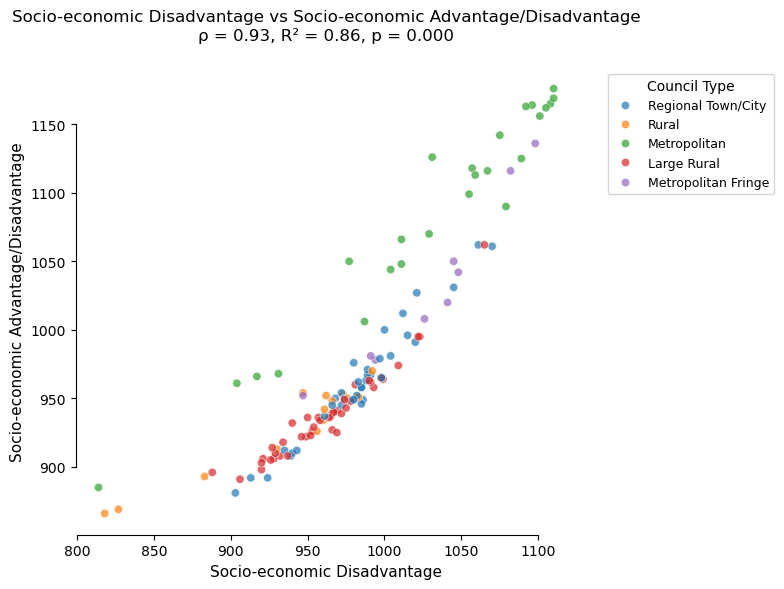

  - Socio-economic Disadvantage vs Socio-economic Advantage/Disadvantage: Correlation is significant (p=0.0000)

Analyzing correlation for Socio-economic Disadvantage and Economic Resources


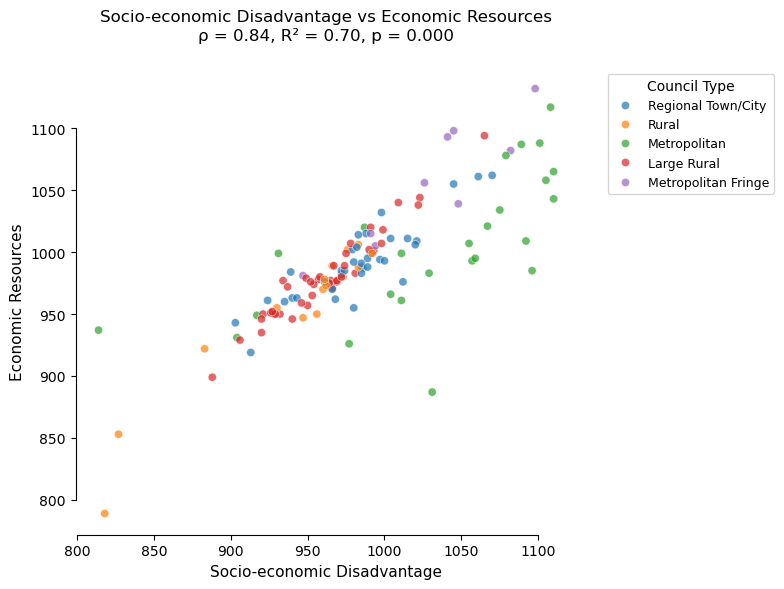

  - Socio-economic Disadvantage vs Economic Resources: Correlation is significant (p=0.0000)

Analyzing correlation for Socio-economic Disadvantage and Education and Occupation


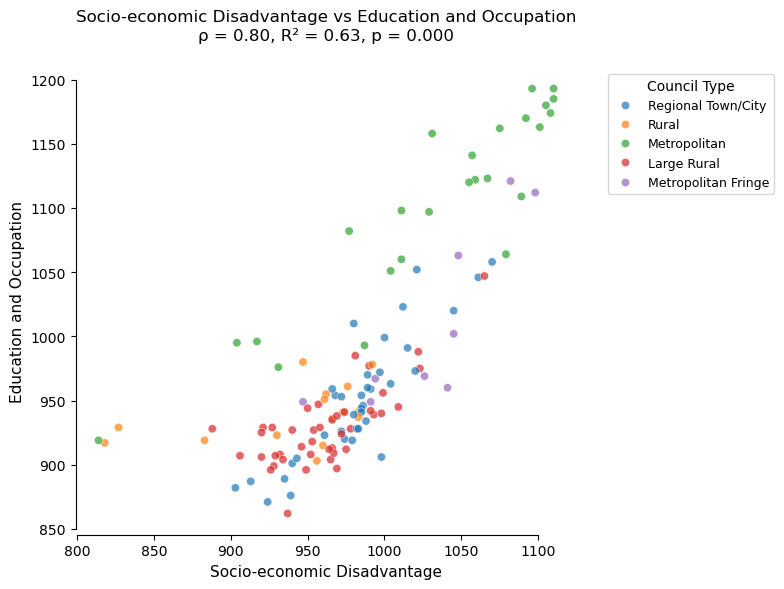

  - Socio-economic Disadvantage vs Education and Occupation: Correlation is significant (p=0.0000)

Analyzing correlation for Socio-economic Disadvantage and Male Mental Health Rate (0-34)


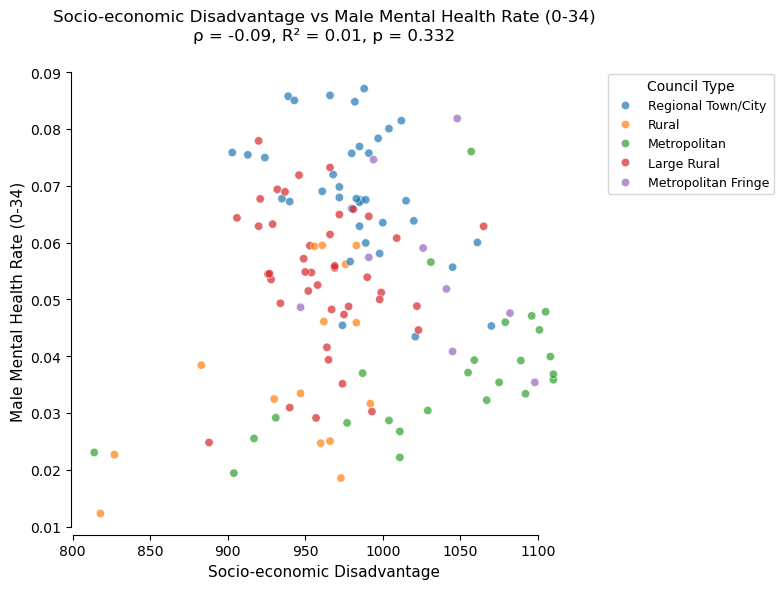

  - Socio-economic Disadvantage vs Male Mental Health Rate (0-34): Correlation is not significant (p=0.3316)

Analyzing correlation for Socio-economic Disadvantage and Male Mental Health Rate (>35)


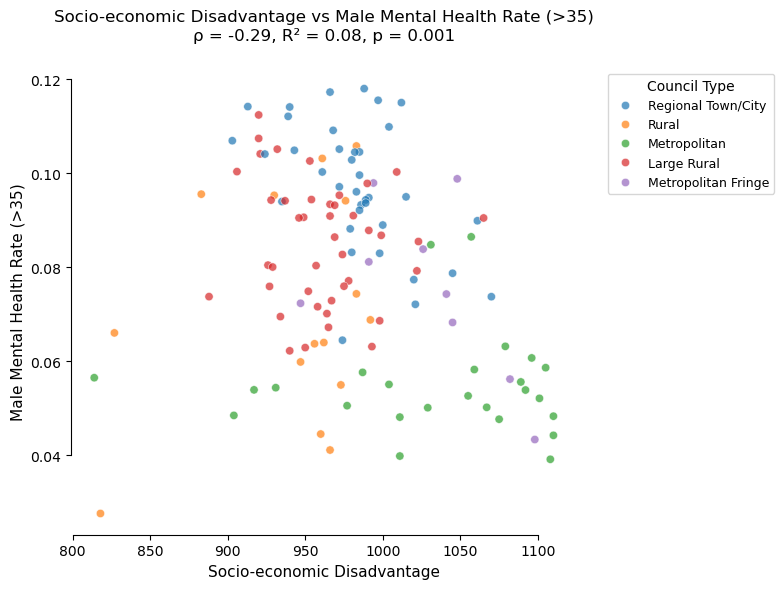

  - Socio-economic Disadvantage vs Male Mental Health Rate (>35): Correlation is significant (p=0.0010)

Analyzing correlation for Socio-economic Disadvantage and Female Mental Health Rate (0-34)


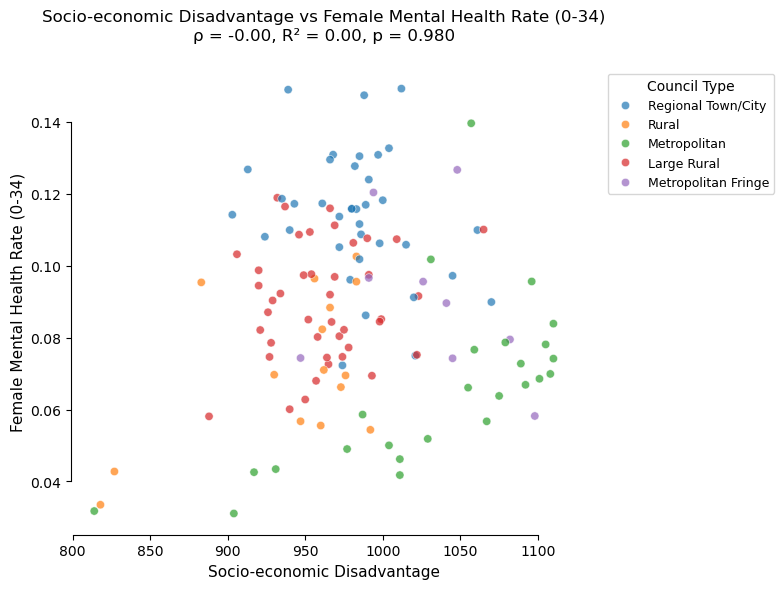

  - Socio-economic Disadvantage vs Female Mental Health Rate (0-34): Correlation is not significant (p=0.9798)

Analyzing correlation for Socio-economic Disadvantage and Female Mental Health Rate (>35)


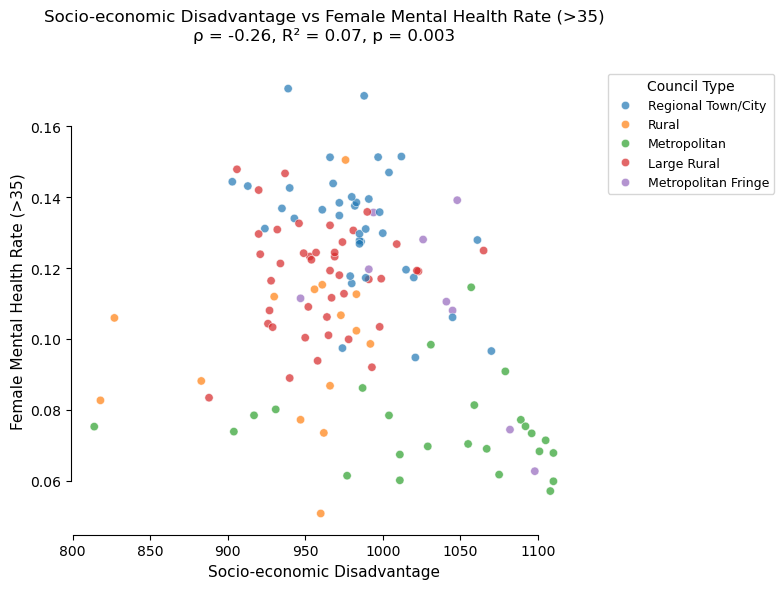

  - Socio-economic Disadvantage vs Female Mental Health Rate (>35): Correlation is significant (p=0.0035)

Analyzing correlation for Socio-economic Disadvantage and Domestic Violence Assault


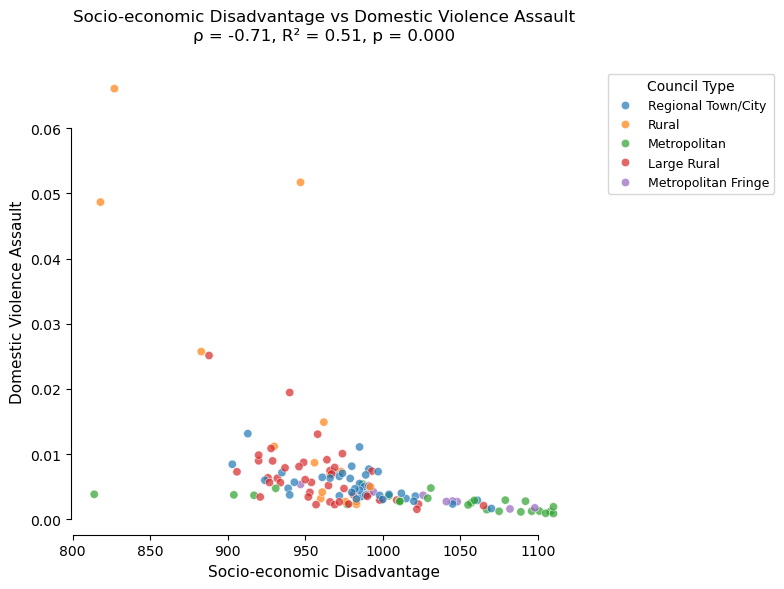

  - Socio-economic Disadvantage vs Domestic Violence Assault: Correlation is significant (p=0.0000)

Analyzing correlation for Socio-economic Disadvantage and Non-domestic Violence Assault


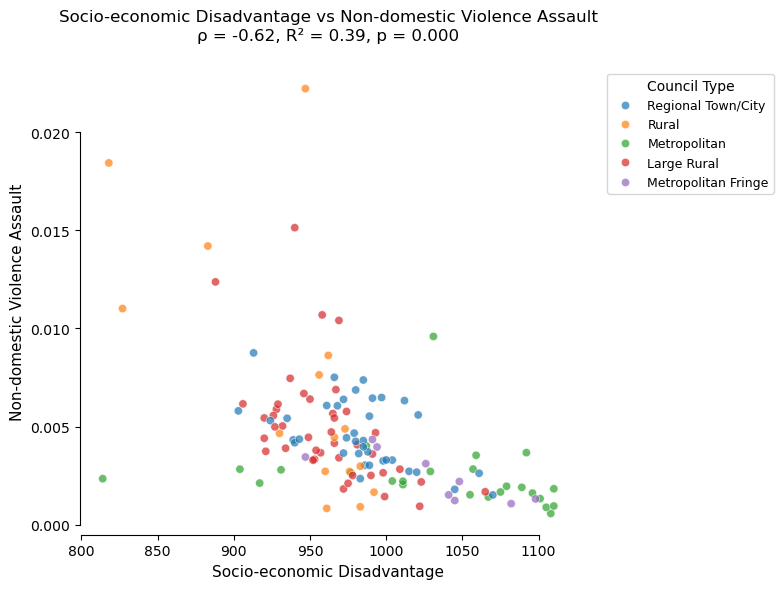

  - Socio-economic Disadvantage vs Non-domestic Violence Assault: Correlation is significant (p=0.0000)

Analyzing correlation for Socio-economic Disadvantage and Assault on Police


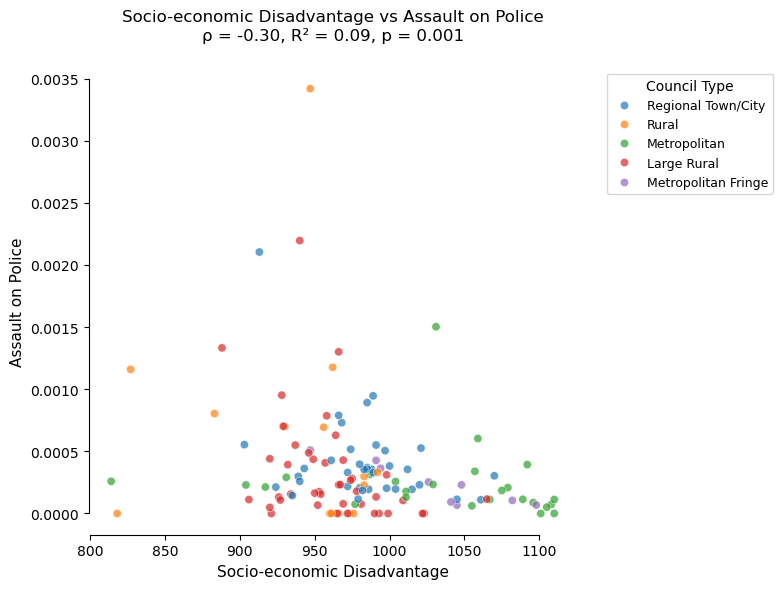

  - Socio-economic Disadvantage vs Assault on Police: Correlation is significant (p=0.0006)

Analyzing correlation for Socio-economic Disadvantage and Sexual Assault


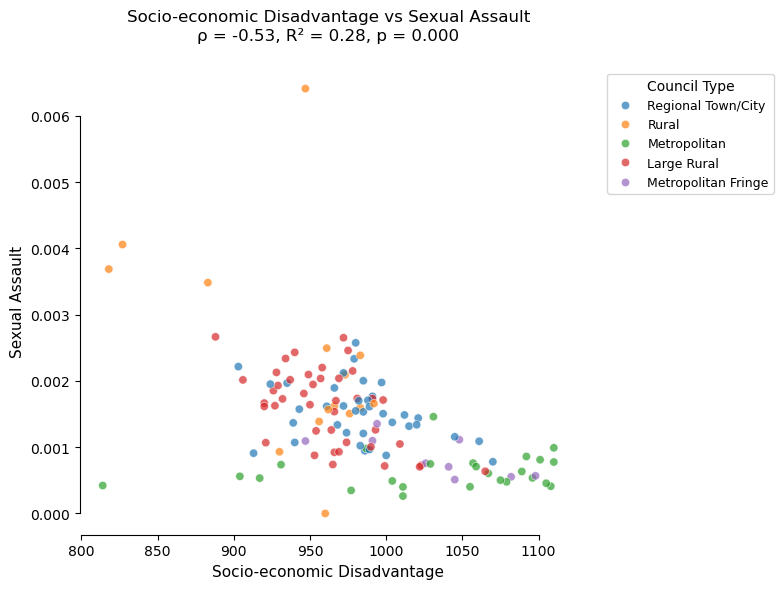

  - Socio-economic Disadvantage vs Sexual Assault: Correlation is significant (p=0.0000)

Analyzing correlation for Socio-economic Disadvantage and Sexual Offences


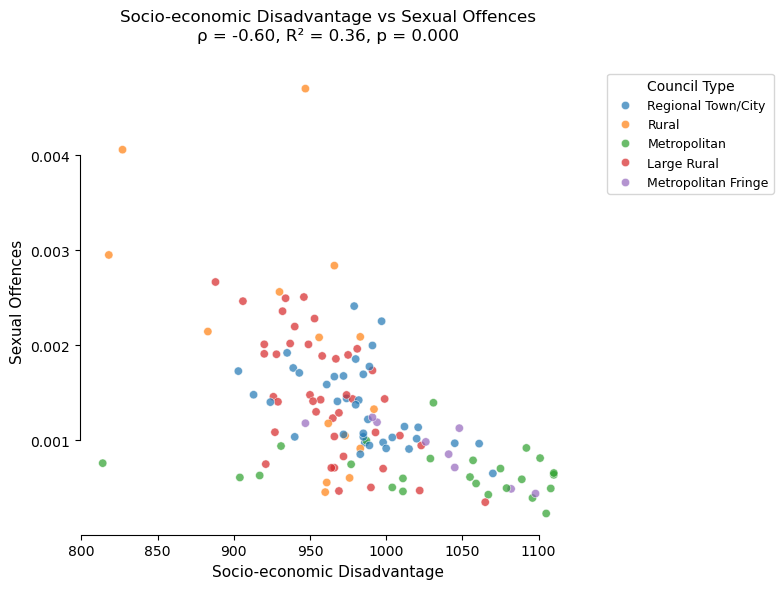

  - Socio-economic Disadvantage vs Sexual Offences: Correlation is significant (p=0.0000)

Analyzing correlation for Socio-economic Disadvantage and Stalking and Harassment


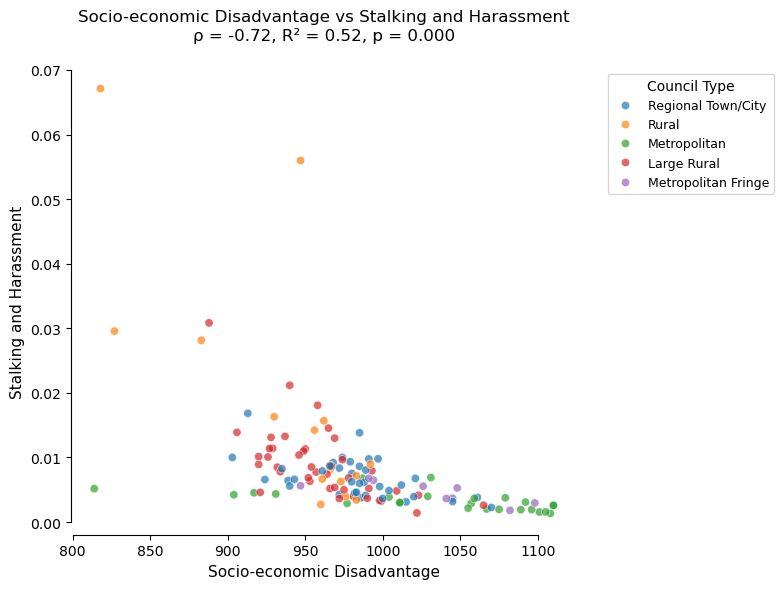

  - Socio-economic Disadvantage vs Stalking and Harassment: Correlation is significant (p=0.0000)

Analyzing correlation for Socio-economic Advantage/Disadvantage and Economic Resources


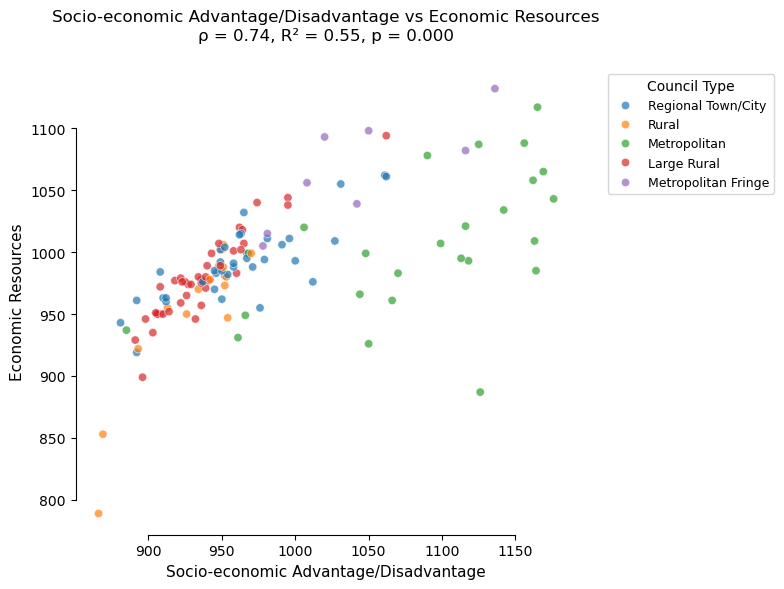

  - Socio-economic Advantage/Disadvantage vs Economic Resources: Correlation is significant (p=0.0000)

Analyzing correlation for Socio-economic Advantage/Disadvantage and Education and Occupation


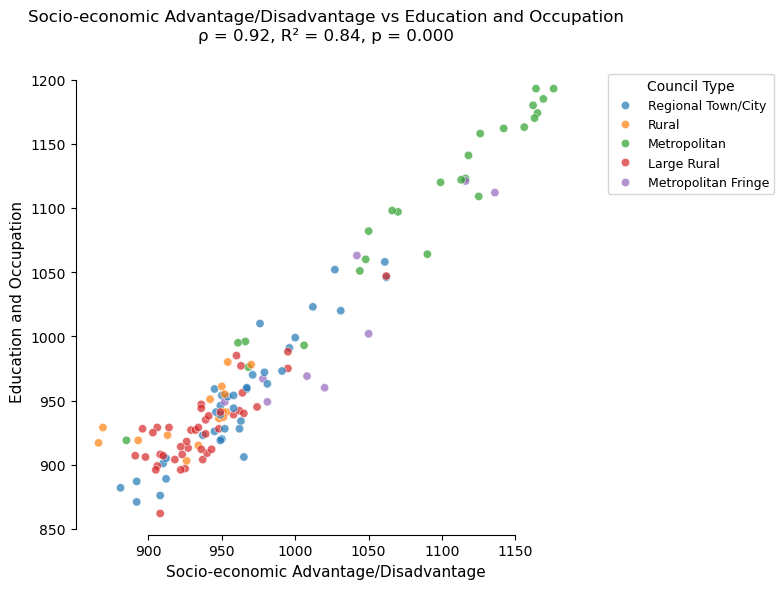

  - Socio-economic Advantage/Disadvantage vs Education and Occupation: Correlation is significant (p=0.0000)

Analyzing correlation for Socio-economic Advantage/Disadvantage and Male Mental Health Rate (0-34)


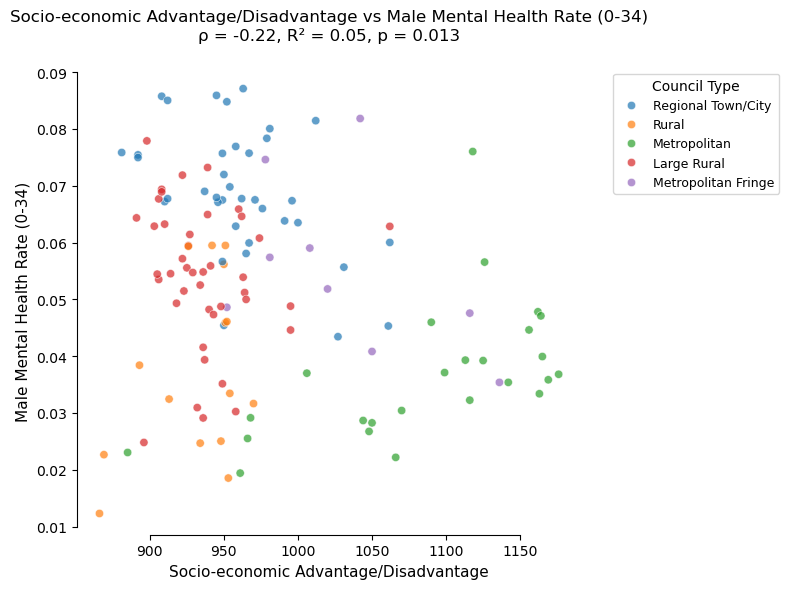

  - Socio-economic Advantage/Disadvantage vs Male Mental Health Rate (0-34): Correlation is significant (p=0.0133)

Analyzing correlation for Socio-economic Advantage/Disadvantage and Male Mental Health Rate (>35)


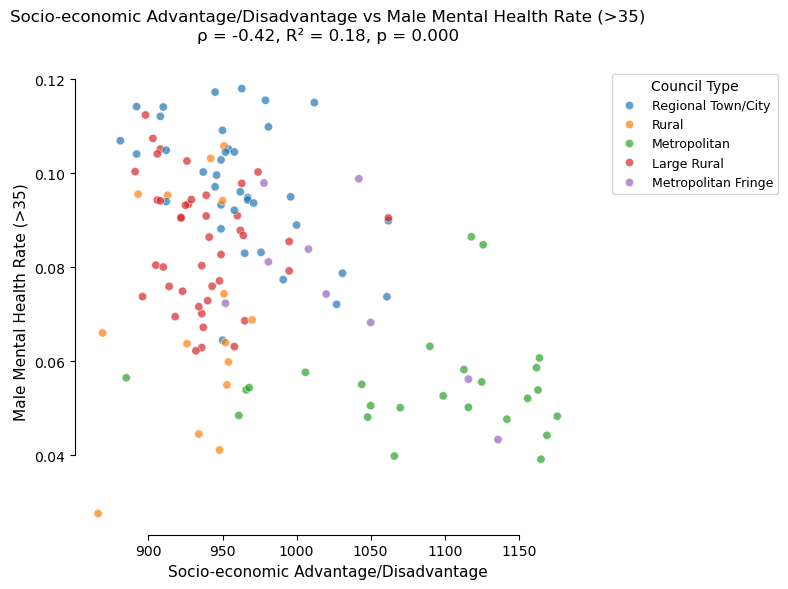

  - Socio-economic Advantage/Disadvantage vs Male Mental Health Rate (>35): Correlation is significant (p=0.0000)

Analyzing correlation for Socio-economic Advantage/Disadvantage and Female Mental Health Rate (0-34)


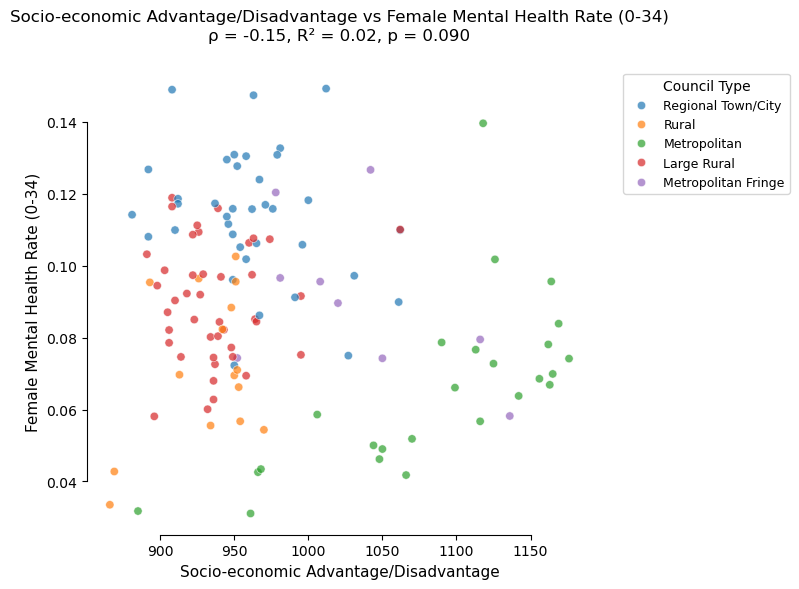

  - Socio-economic Advantage/Disadvantage vs Female Mental Health Rate (0-34): Correlation is not significant (p=0.0902)

Analyzing correlation for Socio-economic Advantage/Disadvantage and Female Mental Health Rate (>35)


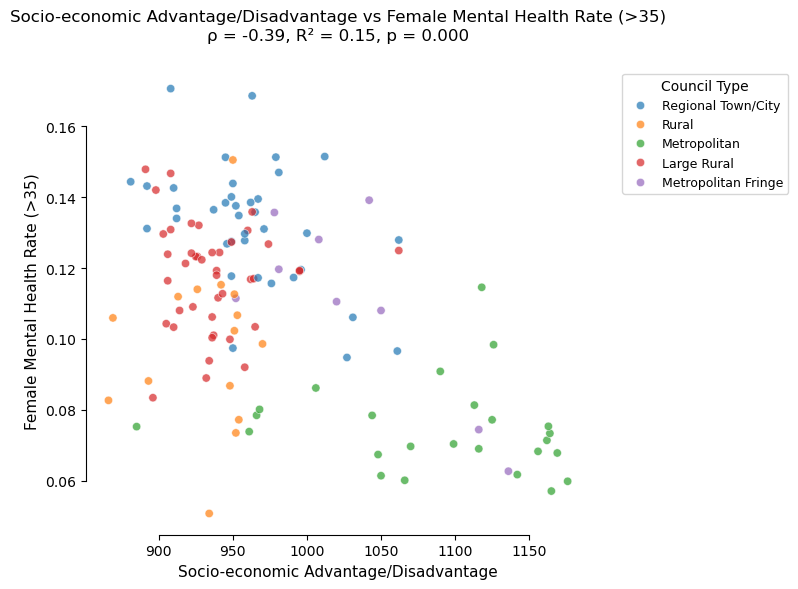

  - Socio-economic Advantage/Disadvantage vs Female Mental Health Rate (>35): Correlation is significant (p=0.0000)

Analyzing correlation for Socio-economic Advantage/Disadvantage and Domestic Violence Assault


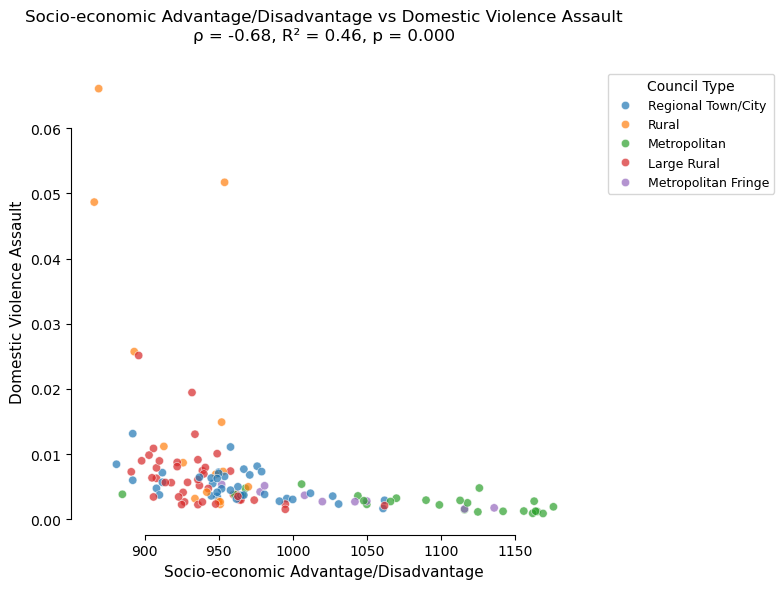

  - Socio-economic Advantage/Disadvantage vs Domestic Violence Assault: Correlation is significant (p=0.0000)

Analyzing correlation for Socio-economic Advantage/Disadvantage and Non-domestic Violence Assault


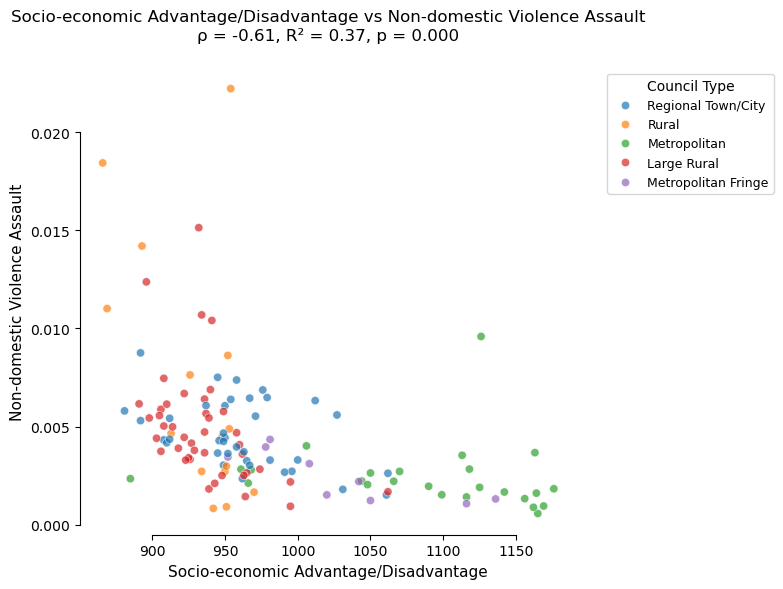

  - Socio-economic Advantage/Disadvantage vs Non-domestic Violence Assault: Correlation is significant (p=0.0000)

Analyzing correlation for Socio-economic Advantage/Disadvantage and Assault on Police


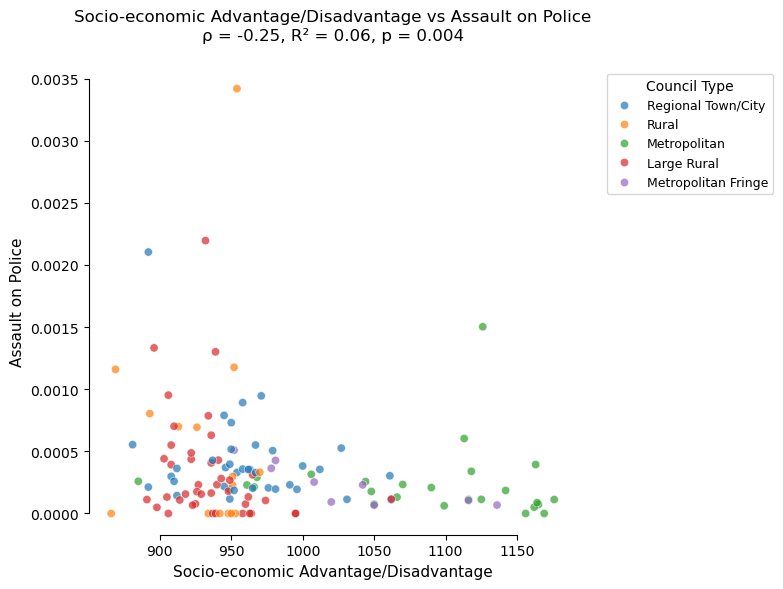

  - Socio-economic Advantage/Disadvantage vs Assault on Police: Correlation is significant (p=0.0042)

Analyzing correlation for Socio-economic Advantage/Disadvantage and Sexual Assault


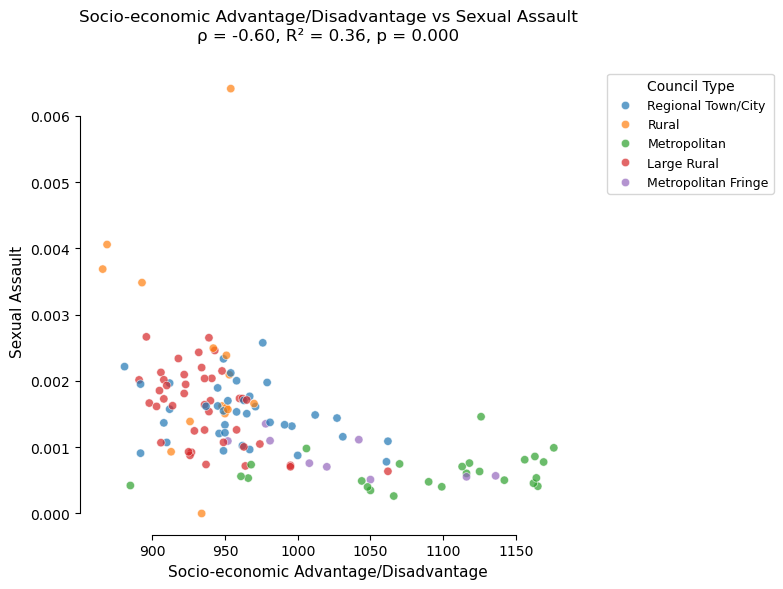

  - Socio-economic Advantage/Disadvantage vs Sexual Assault: Correlation is significant (p=0.0000)

Analyzing correlation for Socio-economic Advantage/Disadvantage and Sexual Offences


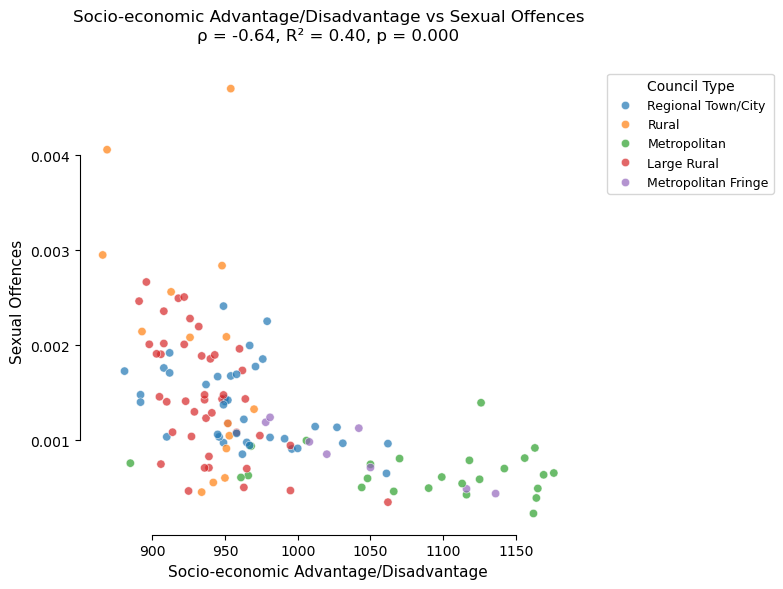

  - Socio-economic Advantage/Disadvantage vs Sexual Offences: Correlation is significant (p=0.0000)

Analyzing correlation for Socio-economic Advantage/Disadvantage and Stalking and Harassment


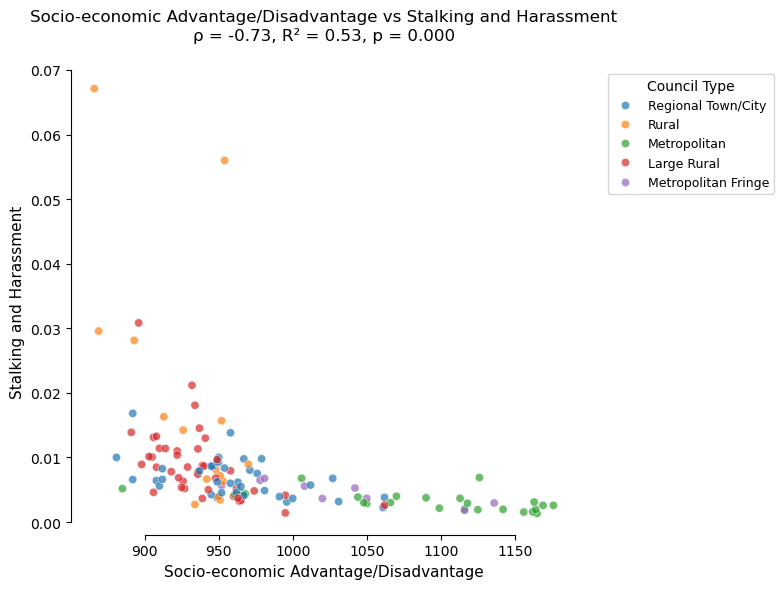

  - Socio-economic Advantage/Disadvantage vs Stalking and Harassment: Correlation is significant (p=0.0000)

Analyzing correlation for Economic Resources and Education and Occupation


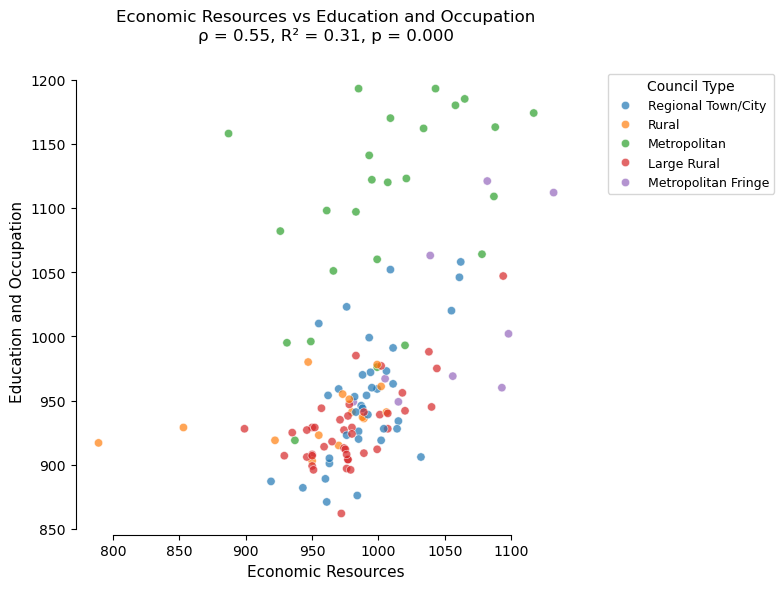

  - Economic Resources vs Education and Occupation: Correlation is significant (p=0.0000)

Analyzing correlation for Economic Resources and Male Mental Health Rate (0-34)


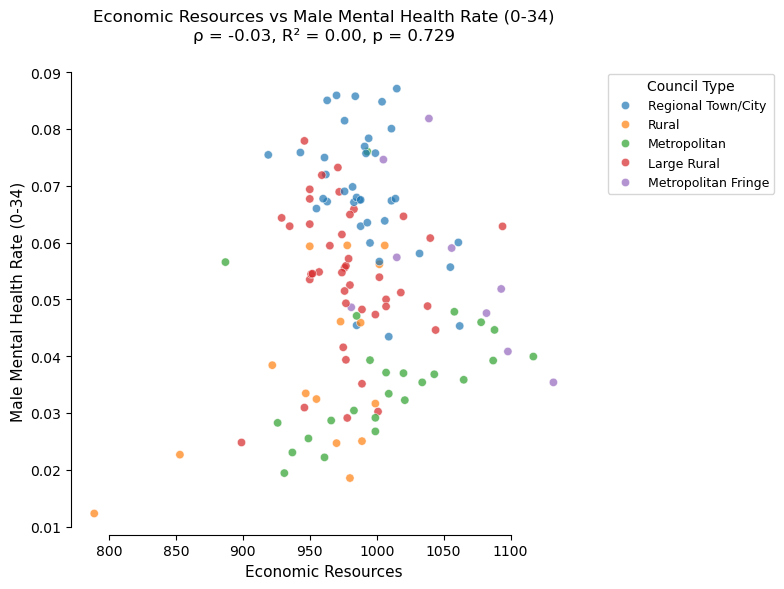

  - Economic Resources vs Male Mental Health Rate (0-34): Correlation is not significant (p=0.7289)

Analyzing correlation for Economic Resources and Male Mental Health Rate (>35)


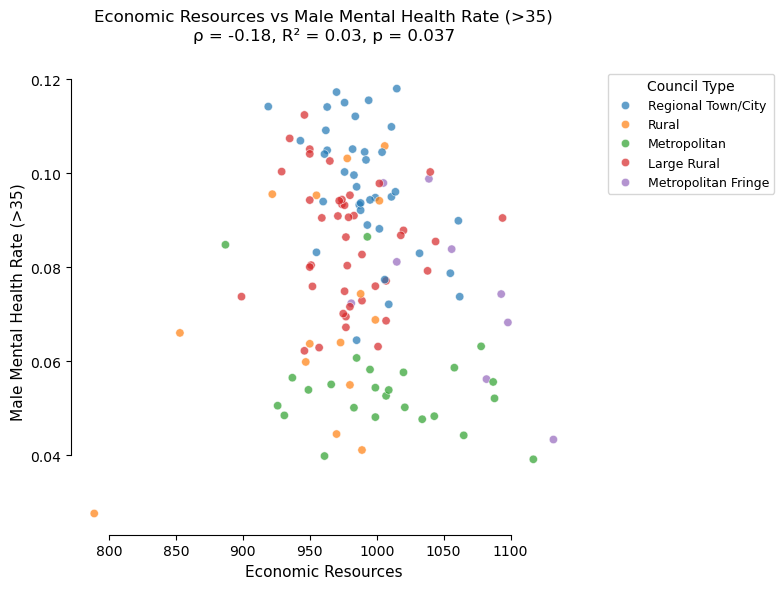

  - Economic Resources vs Male Mental Health Rate (>35): Correlation is significant (p=0.0372)

Analyzing correlation for Economic Resources and Female Mental Health Rate (0-34)


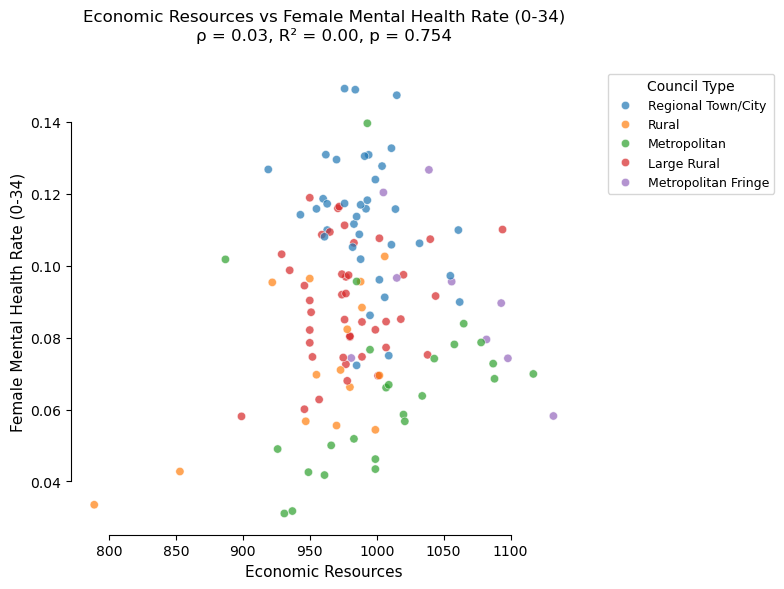

  - Economic Resources vs Female Mental Health Rate (0-34): Correlation is not significant (p=0.7542)

Analyzing correlation for Economic Resources and Female Mental Health Rate (>35)


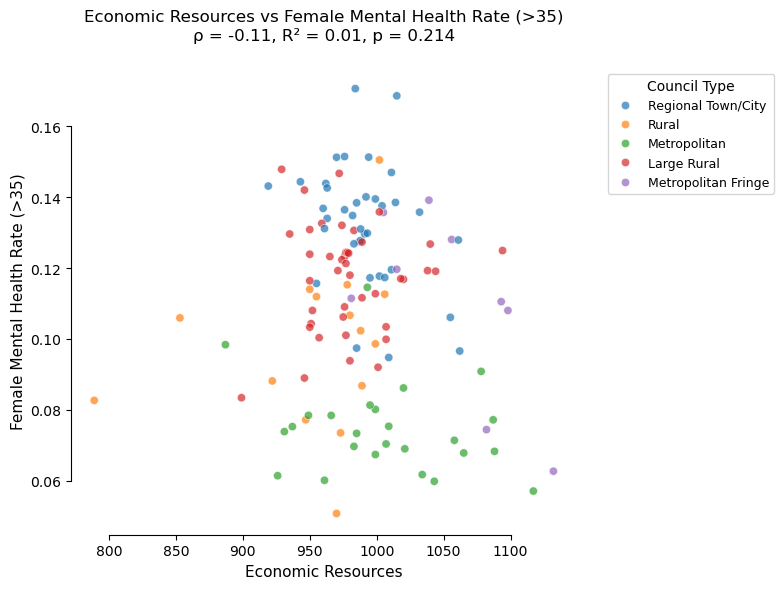

  - Economic Resources vs Female Mental Health Rate (>35): Correlation is not significant (p=0.2144)

Analyzing correlation for Economic Resources and Domestic Violence Assault


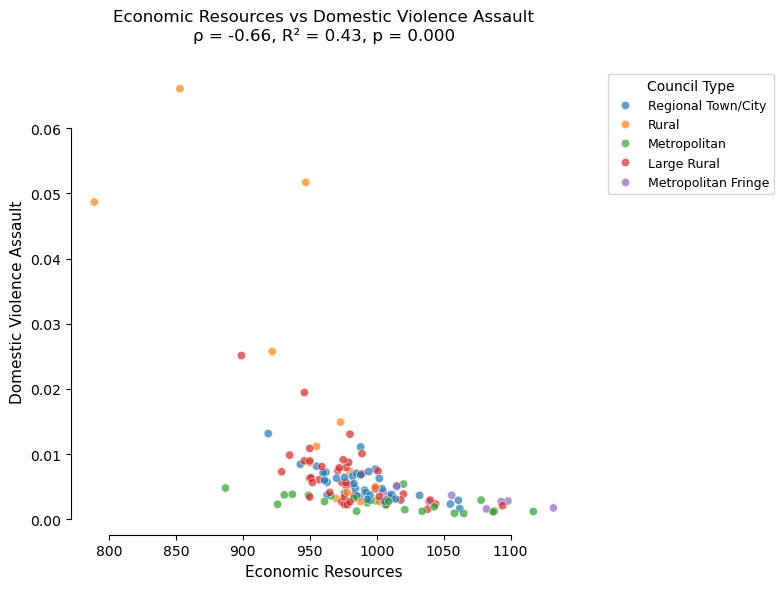

  - Economic Resources vs Domestic Violence Assault: Correlation is significant (p=0.0000)

Analyzing correlation for Economic Resources and Non-domestic Violence Assault


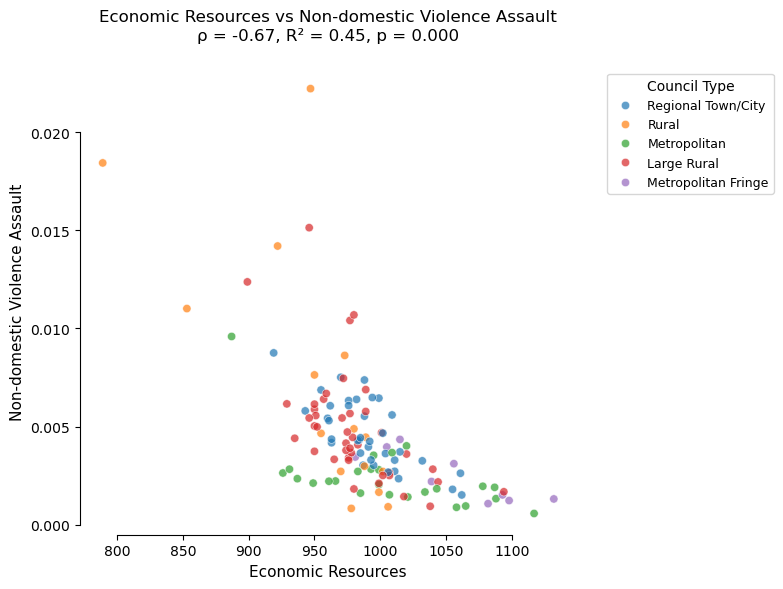

  - Economic Resources vs Non-domestic Violence Assault: Correlation is significant (p=0.0000)

Analyzing correlation for Economic Resources and Assault on Police


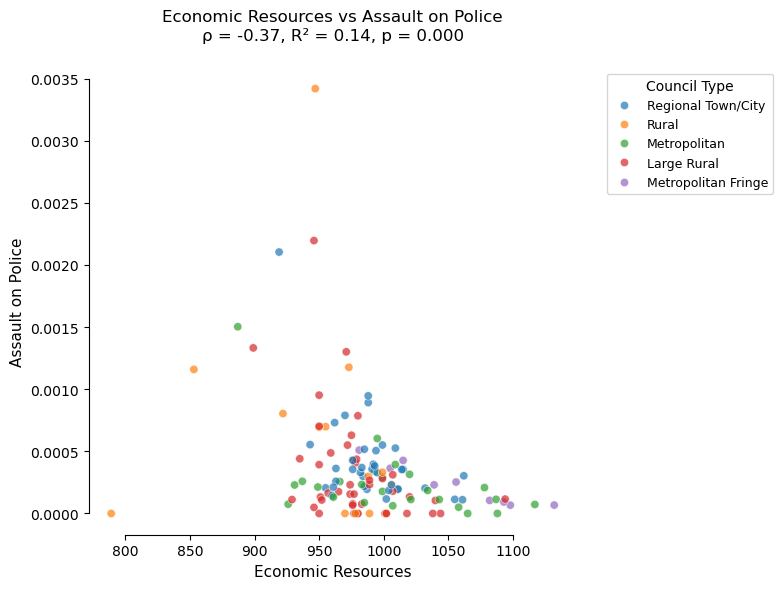

  - Economic Resources vs Assault on Police: Correlation is significant (p=0.0000)

Analyzing correlation for Economic Resources and Sexual Assault


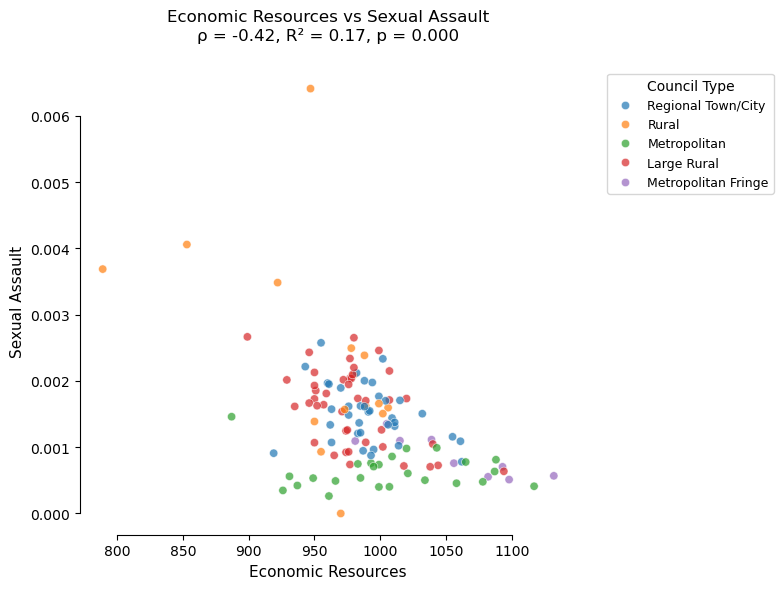

  - Economic Resources vs Sexual Assault: Correlation is significant (p=0.0000)

Analyzing correlation for Economic Resources and Sexual Offences


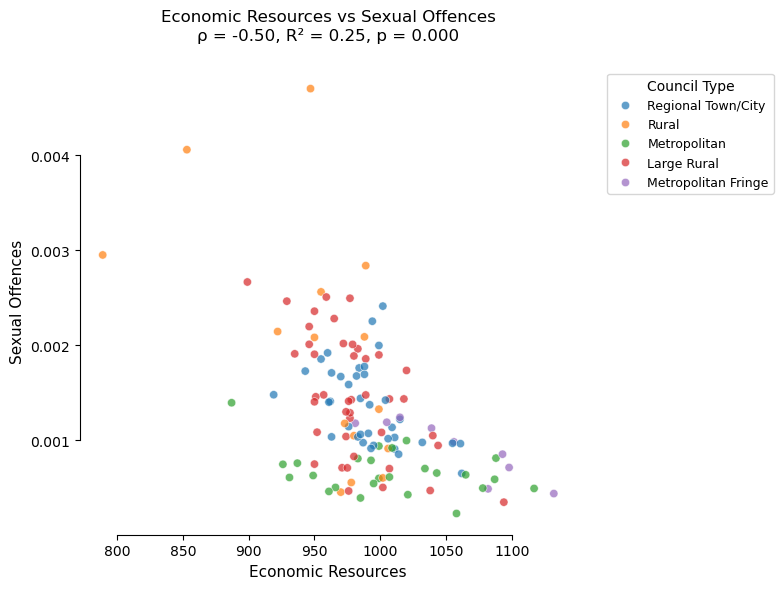

  - Economic Resources vs Sexual Offences: Correlation is significant (p=0.0000)

Analyzing correlation for Economic Resources and Stalking and Harassment


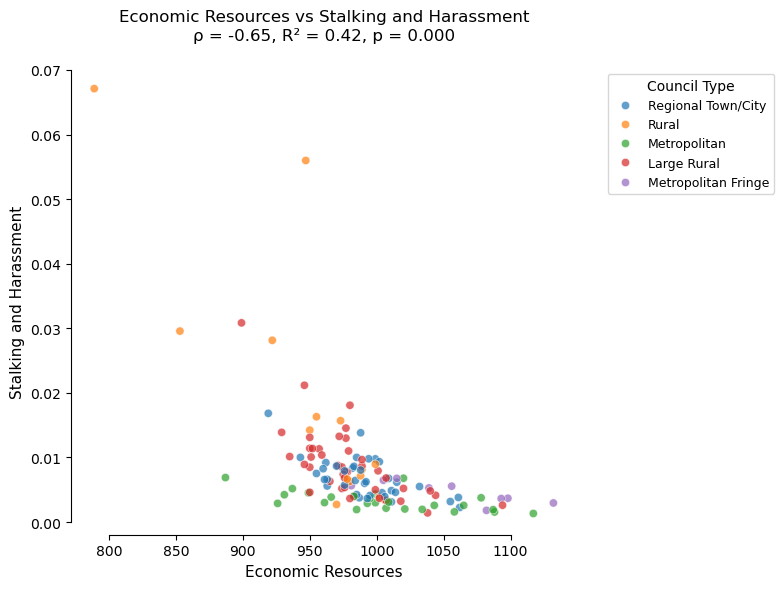

  - Economic Resources vs Stalking and Harassment: Correlation is significant (p=0.0000)

Analyzing correlation for Education and Occupation and Male Mental Health Rate (0-34)


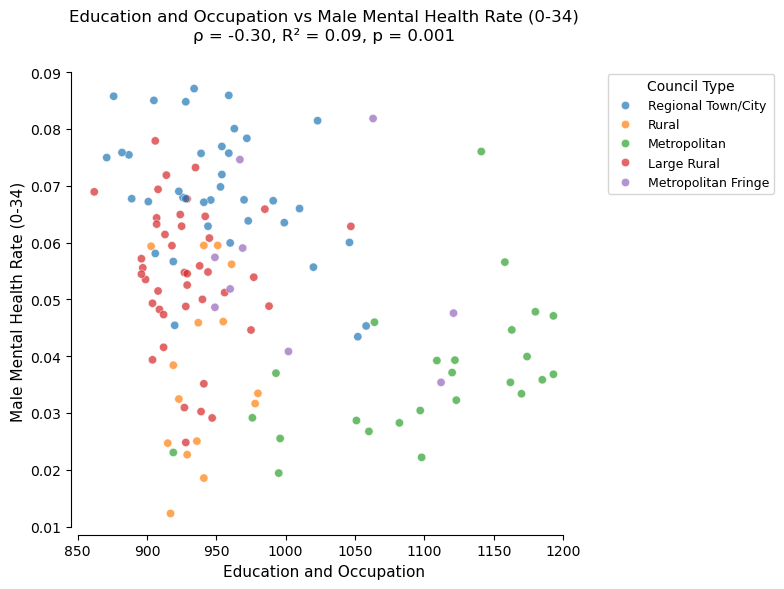

  - Education and Occupation vs Male Mental Health Rate (0-34): Correlation is significant (p=0.0007)

Analyzing correlation for Education and Occupation and Male Mental Health Rate (>35)


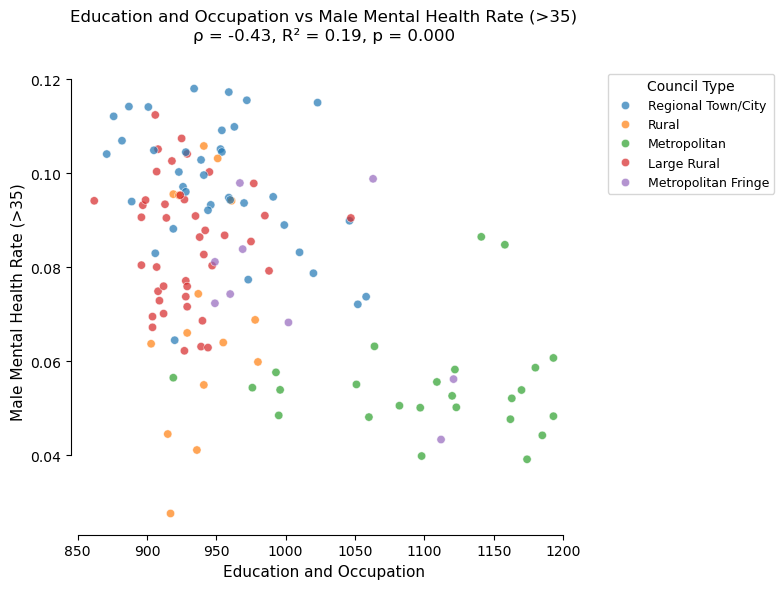

  - Education and Occupation vs Male Mental Health Rate (>35): Correlation is significant (p=0.0000)

Analyzing correlation for Education and Occupation and Female Mental Health Rate (0-34)


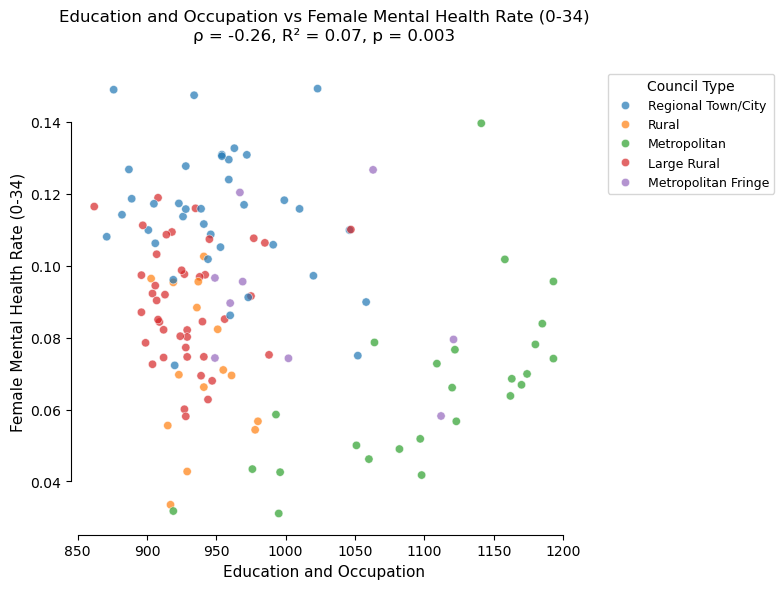

  - Education and Occupation vs Female Mental Health Rate (0-34): Correlation is significant (p=0.0027)

Analyzing correlation for Education and Occupation and Female Mental Health Rate (>35)


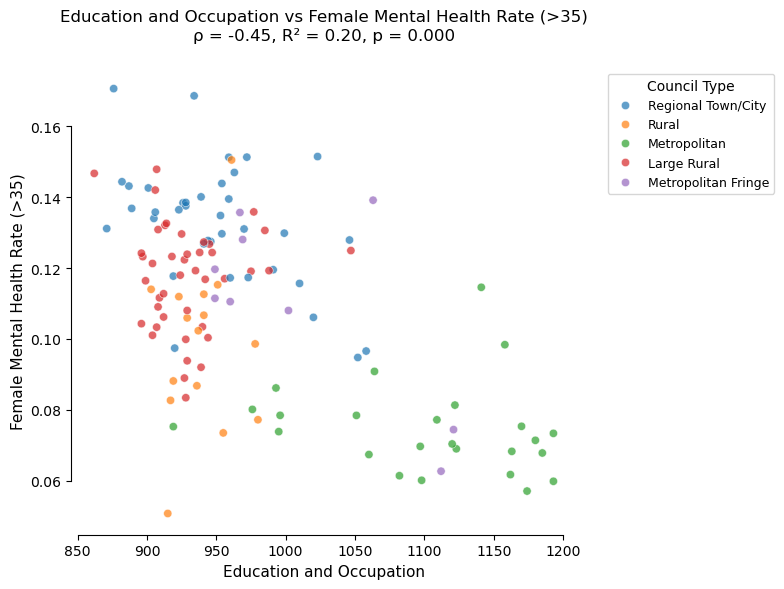

  - Education and Occupation vs Female Mental Health Rate (>35): Correlation is significant (p=0.0000)

Analyzing correlation for Education and Occupation and Domestic Violence Assault


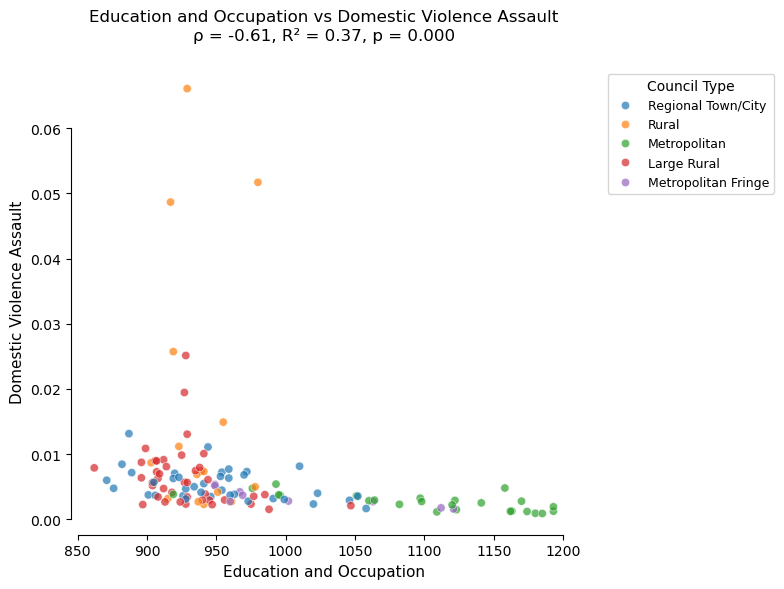

  - Education and Occupation vs Domestic Violence Assault: Correlation is significant (p=0.0000)

Analyzing correlation for Education and Occupation and Non-domestic Violence Assault


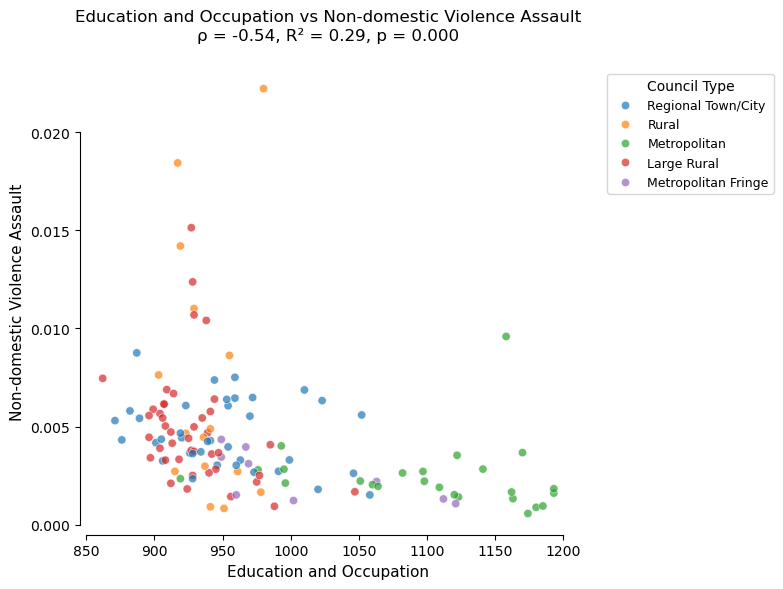

  - Education and Occupation vs Non-domestic Violence Assault: Correlation is significant (p=0.0000)

Analyzing correlation for Education and Occupation and Assault on Police


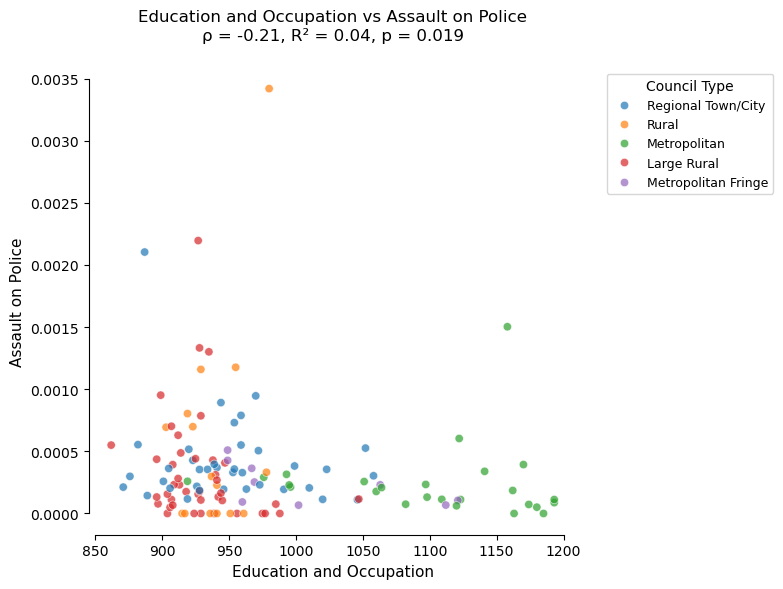

  - Education and Occupation vs Assault on Police: Correlation is significant (p=0.0188)

Analyzing correlation for Education and Occupation and Sexual Assault


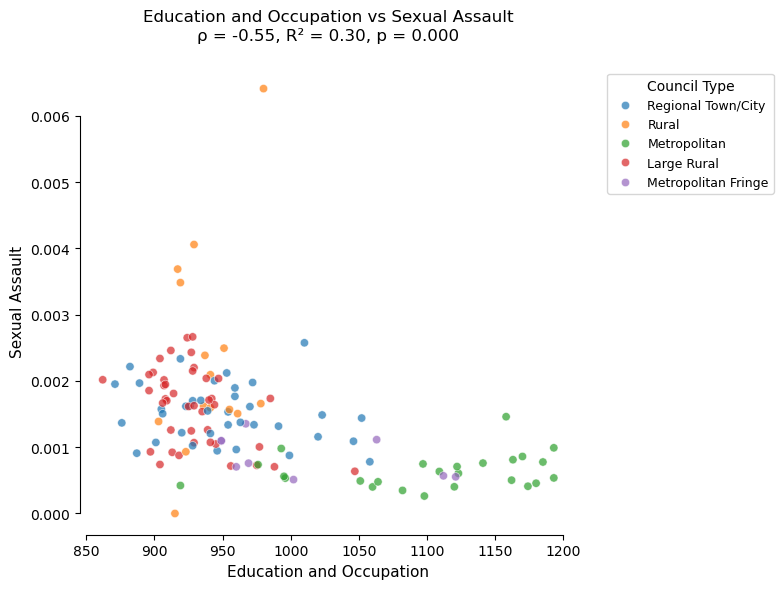

  - Education and Occupation vs Sexual Assault: Correlation is significant (p=0.0000)

Analyzing correlation for Education and Occupation and Sexual Offences


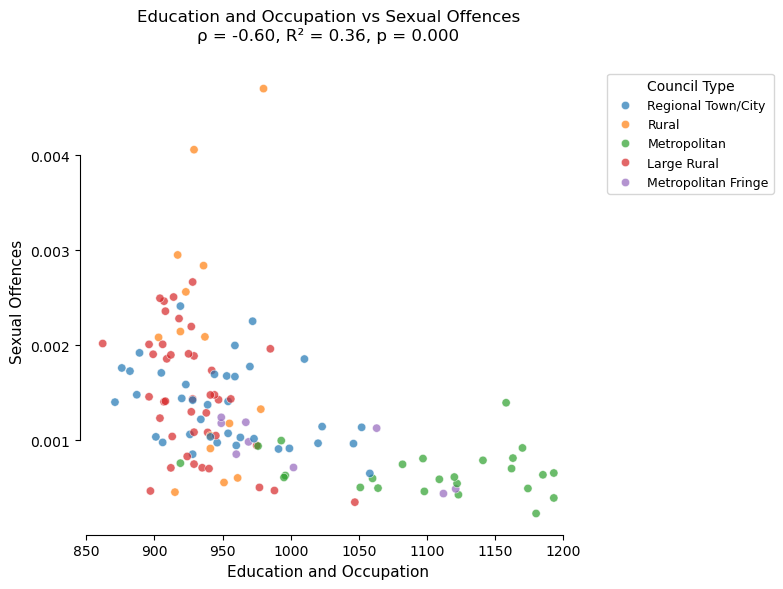

  - Education and Occupation vs Sexual Offences: Correlation is significant (p=0.0000)

Analyzing correlation for Education and Occupation and Stalking and Harassment


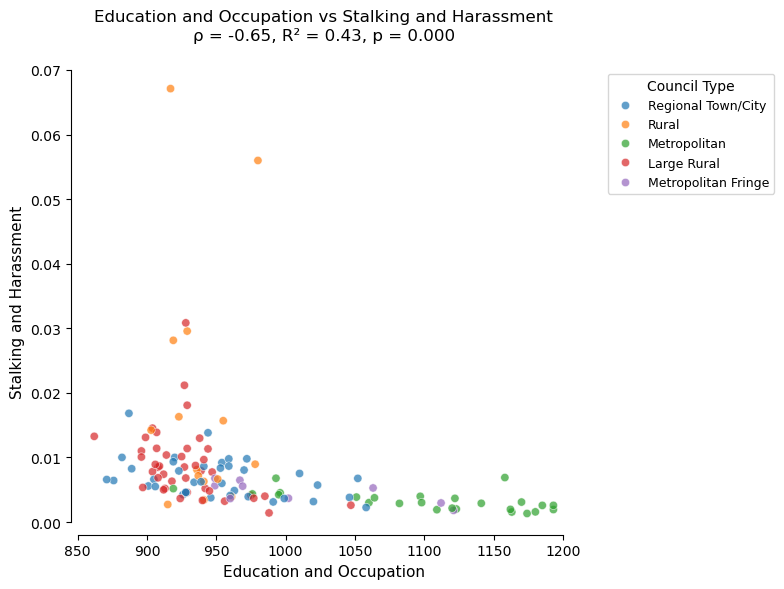

  - Education and Occupation vs Stalking and Harassment: Correlation is significant (p=0.0000)

Analyzing correlation for Male Mental Health Rate (0-34) and Male Mental Health Rate (>35)


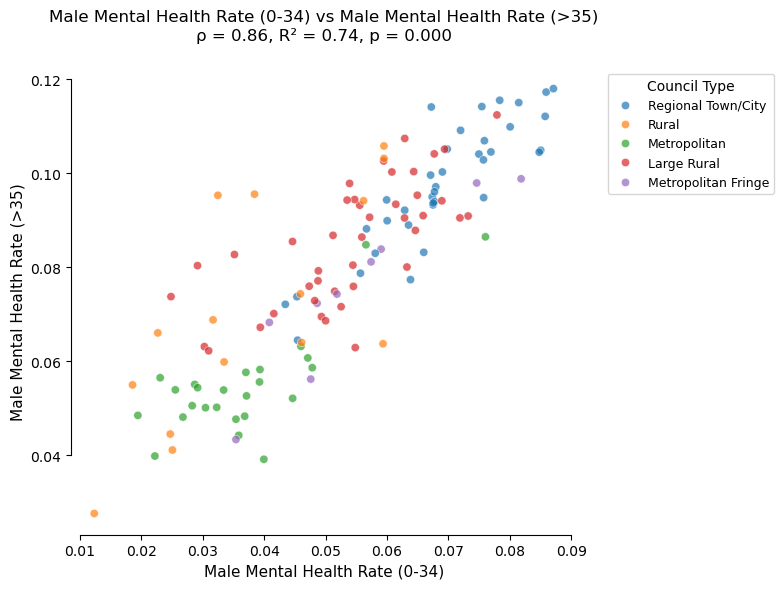

  - Male Mental Health Rate (0-34) vs Male Mental Health Rate (>35): Correlation is significant (p=0.0000)

Analyzing correlation for Male Mental Health Rate (0-34) and Female Mental Health Rate (0-34)


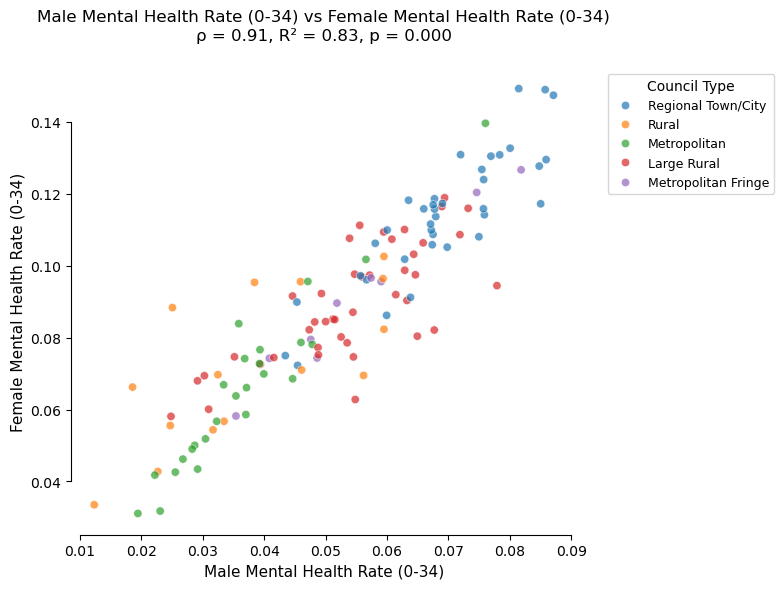

  - Male Mental Health Rate (0-34) vs Female Mental Health Rate (0-34): Correlation is significant (p=0.0000)

Analyzing correlation for Male Mental Health Rate (0-34) and Female Mental Health Rate (>35)


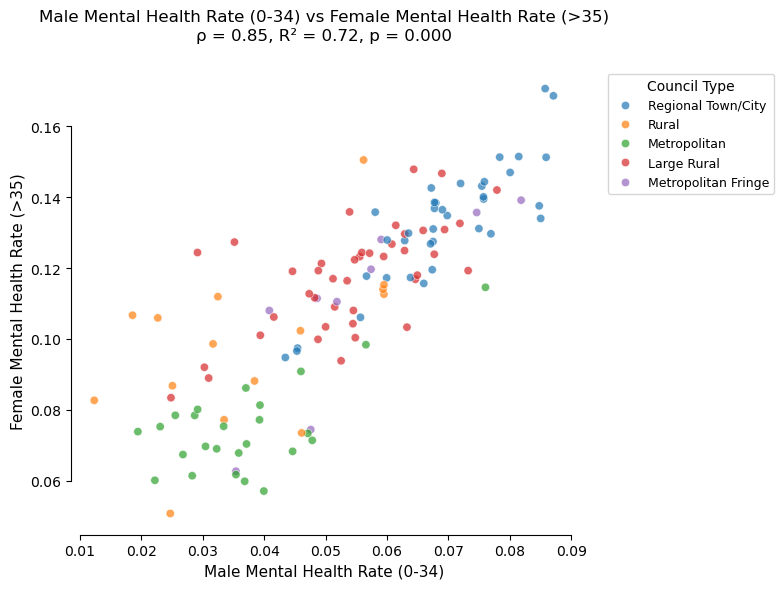

  - Male Mental Health Rate (0-34) vs Female Mental Health Rate (>35): Correlation is significant (p=0.0000)

Analyzing correlation for Male Mental Health Rate (0-34) and Domestic Violence Assault


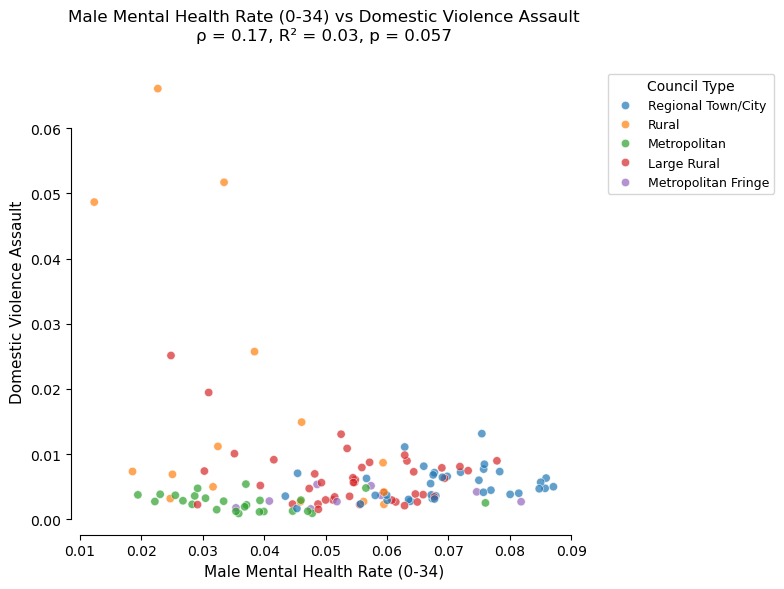

  - Male Mental Health Rate (0-34) vs Domestic Violence Assault: Correlation is not significant (p=0.0566)

Analyzing correlation for Male Mental Health Rate (0-34) and Non-domestic Violence Assault


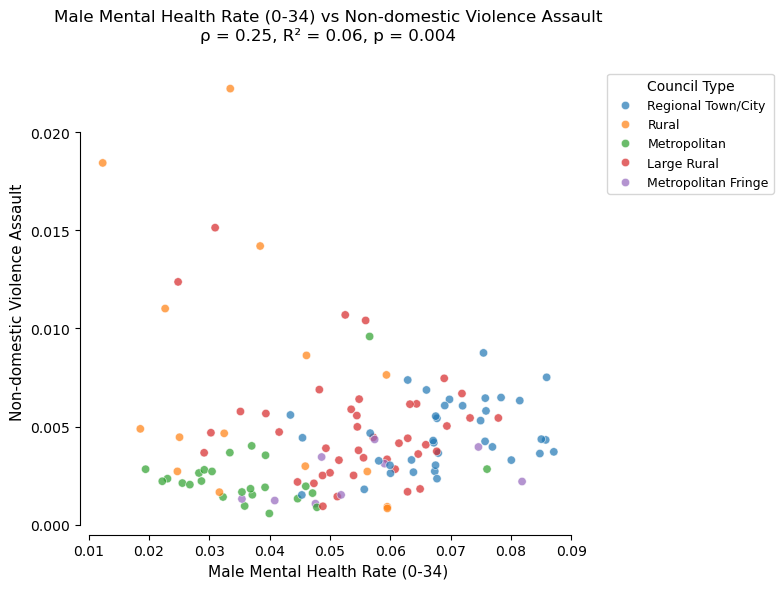

  - Male Mental Health Rate (0-34) vs Non-domestic Violence Assault: Correlation is significant (p=0.0038)

Analyzing correlation for Male Mental Health Rate (0-34) and Assault on Police


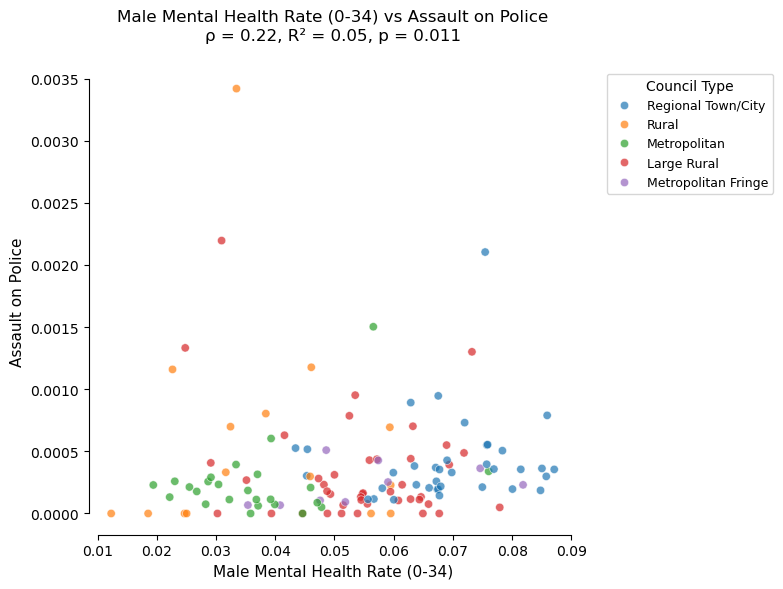

  - Male Mental Health Rate (0-34) vs Assault on Police: Correlation is significant (p=0.0112)

Analyzing correlation for Male Mental Health Rate (0-34) and Sexual Assault


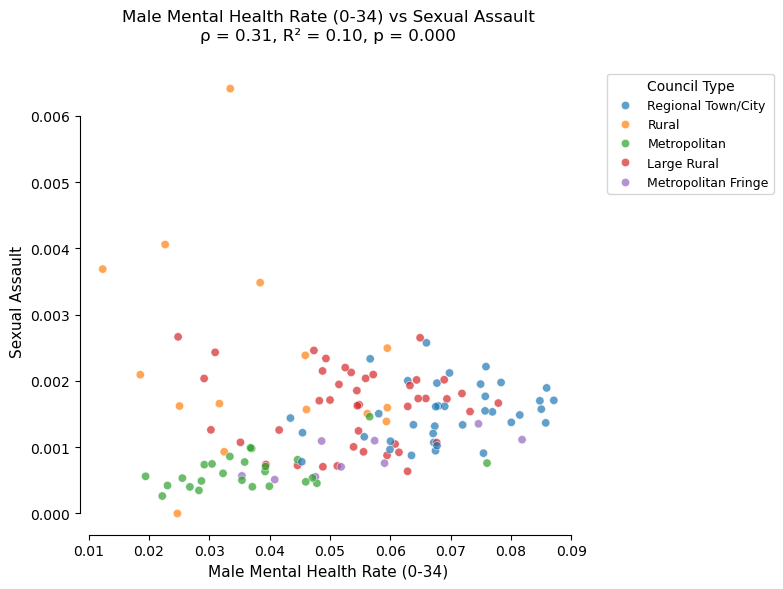

  - Male Mental Health Rate (0-34) vs Sexual Assault: Correlation is significant (p=0.0004)

Analyzing correlation for Male Mental Health Rate (0-34) and Sexual Offences


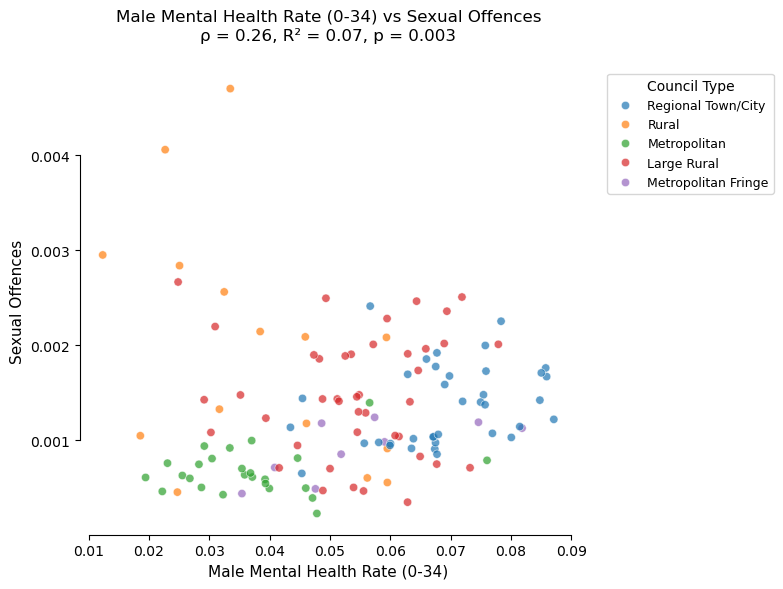

  - Male Mental Health Rate (0-34) vs Sexual Offences: Correlation is significant (p=0.0028)

Analyzing correlation for Male Mental Health Rate (0-34) and Stalking and Harassment


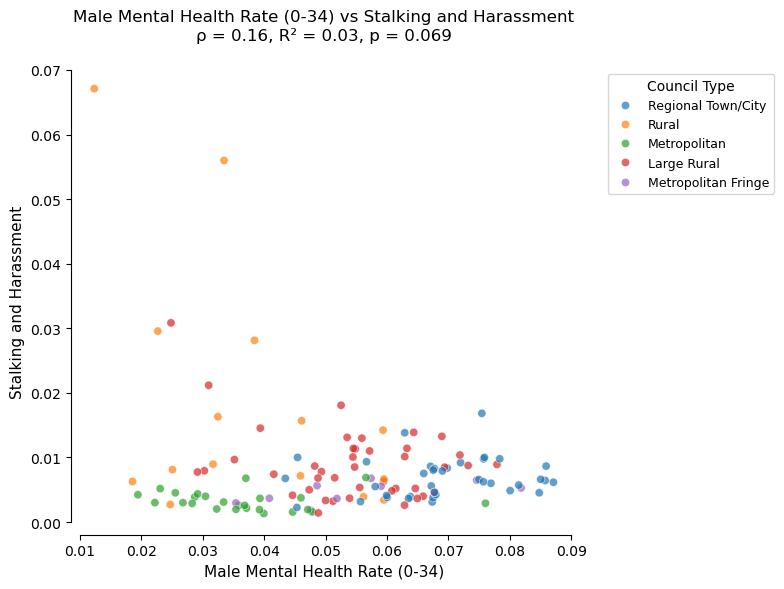

  - Male Mental Health Rate (0-34) vs Stalking and Harassment: Correlation is not significant (p=0.0695)

Analyzing correlation for Male Mental Health Rate (>35) and Female Mental Health Rate (0-34)


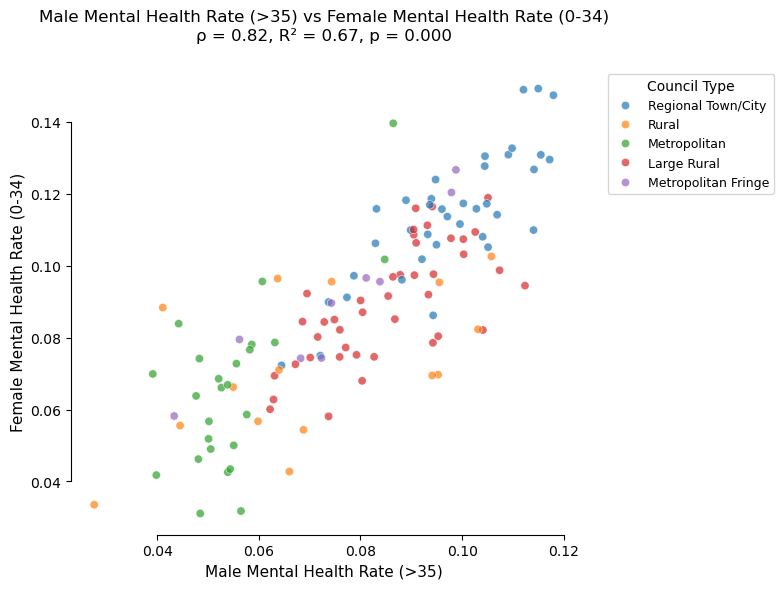

  - Male Mental Health Rate (>35) vs Female Mental Health Rate (0-34): Correlation is significant (p=0.0000)

Analyzing correlation for Male Mental Health Rate (>35) and Female Mental Health Rate (>35)


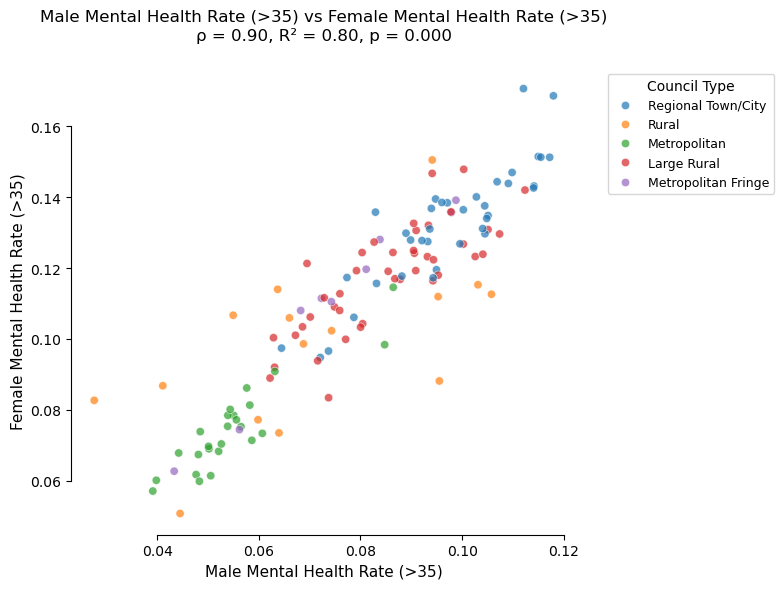

  - Male Mental Health Rate (>35) vs Female Mental Health Rate (>35): Correlation is significant (p=0.0000)

Analyzing correlation for Male Mental Health Rate (>35) and Domestic Violence Assault


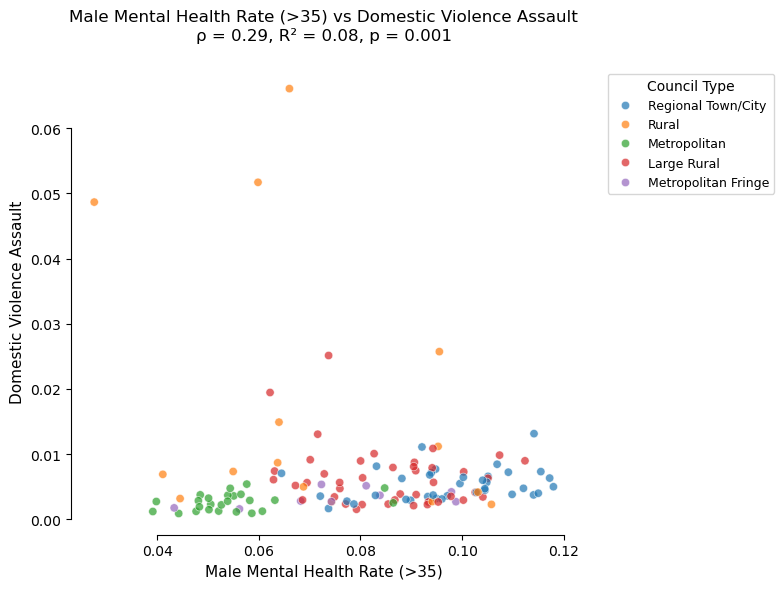

  - Male Mental Health Rate (>35) vs Domestic Violence Assault: Correlation is significant (p=0.0010)

Analyzing correlation for Male Mental Health Rate (>35) and Non-domestic Violence Assault


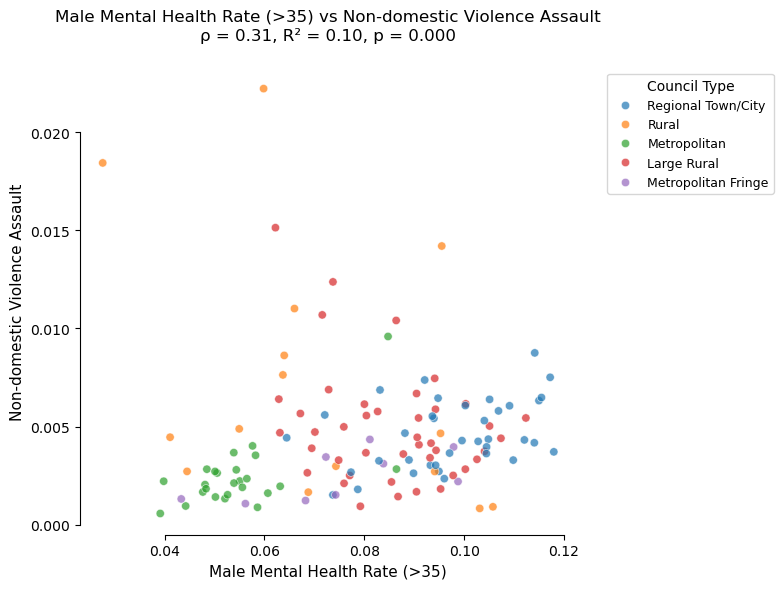

  - Male Mental Health Rate (>35) vs Non-domestic Violence Assault: Correlation is significant (p=0.0004)

Analyzing correlation for Male Mental Health Rate (>35) and Assault on Police


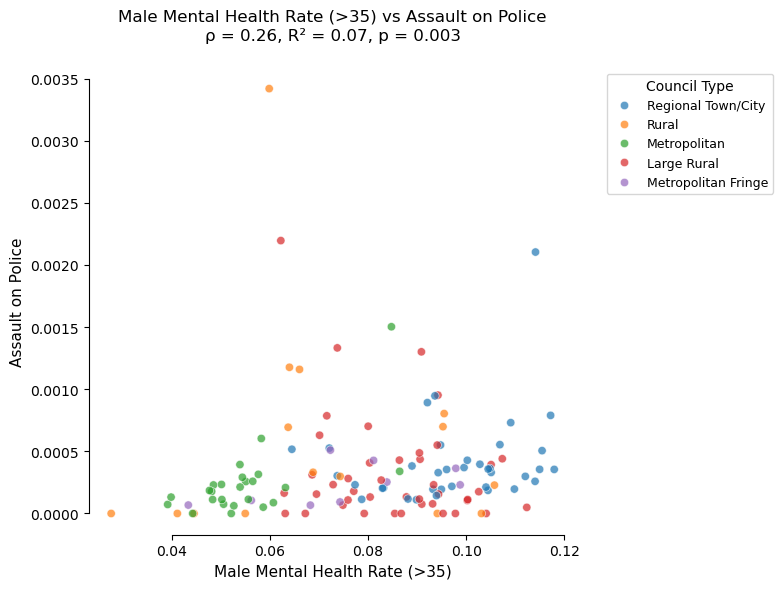

  - Male Mental Health Rate (>35) vs Assault on Police: Correlation is significant (p=0.0030)

Analyzing correlation for Male Mental Health Rate (>35) and Sexual Assault


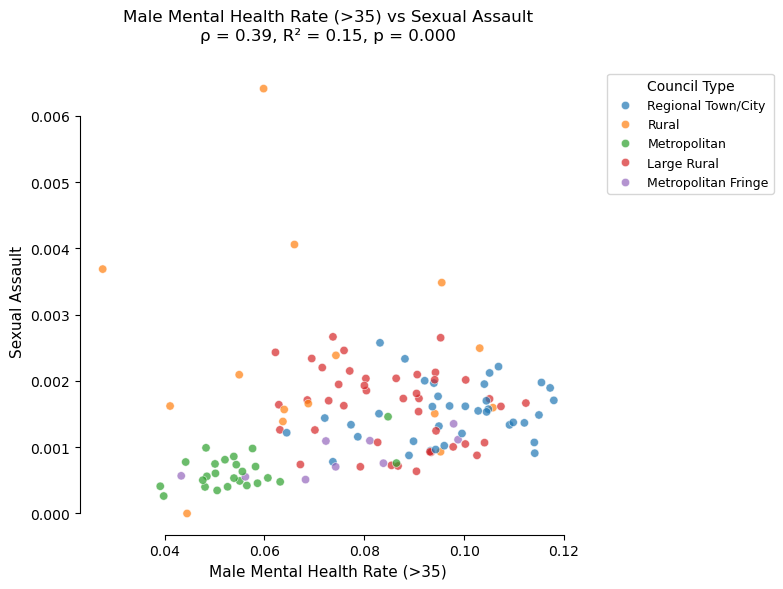

  - Male Mental Health Rate (>35) vs Sexual Assault: Correlation is significant (p=0.0000)

Analyzing correlation for Male Mental Health Rate (>35) and Sexual Offences


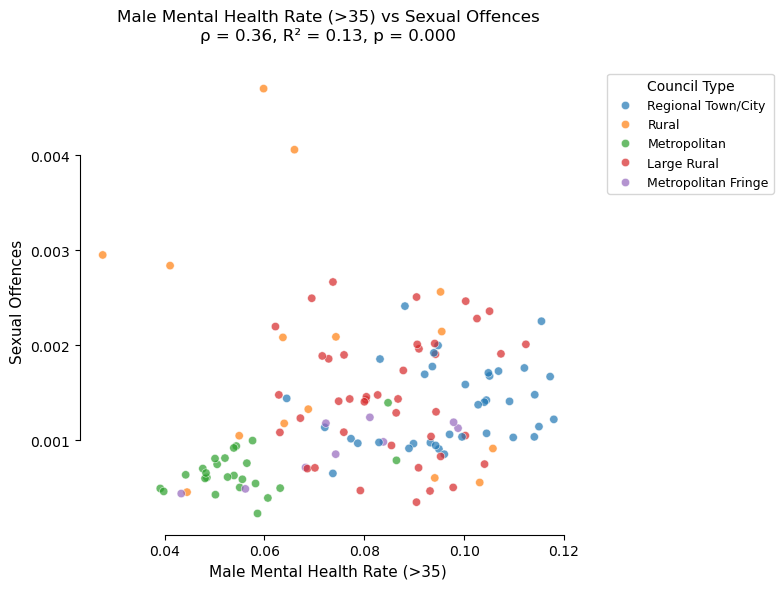

  - Male Mental Health Rate (>35) vs Sexual Offences: Correlation is significant (p=0.0000)

Analyzing correlation for Male Mental Health Rate (>35) and Stalking and Harassment


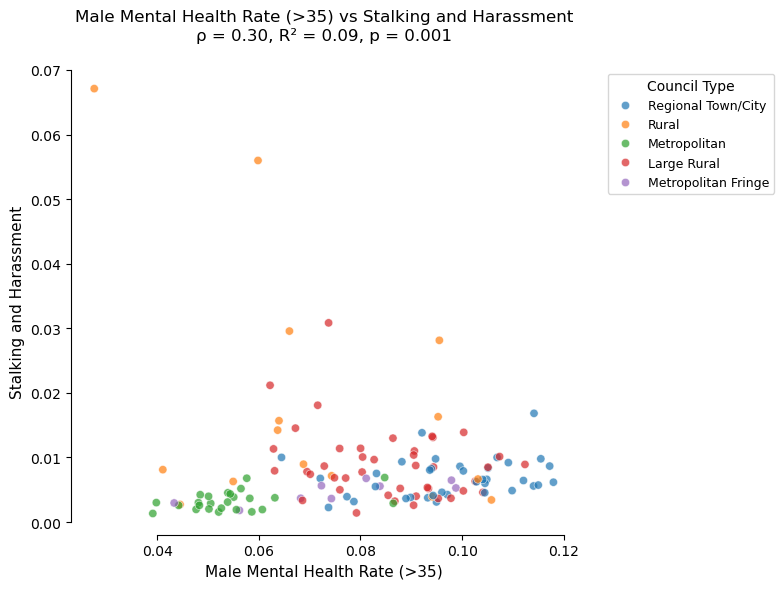

  - Male Mental Health Rate (>35) vs Stalking and Harassment: Correlation is significant (p=0.0005)

Analyzing correlation for Female Mental Health Rate (0-34) and Female Mental Health Rate (>35)


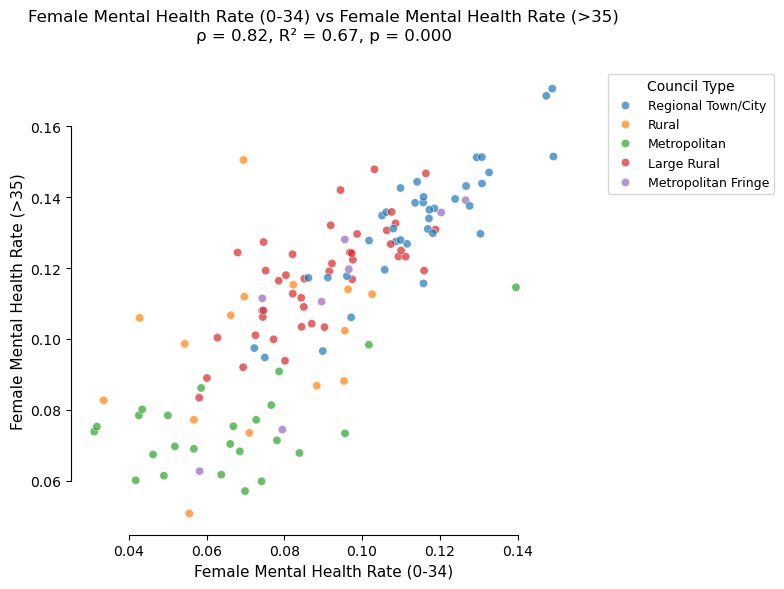

  - Female Mental Health Rate (0-34) vs Female Mental Health Rate (>35): Correlation is significant (p=0.0000)

Analyzing correlation for Female Mental Health Rate (0-34) and Domestic Violence Assault


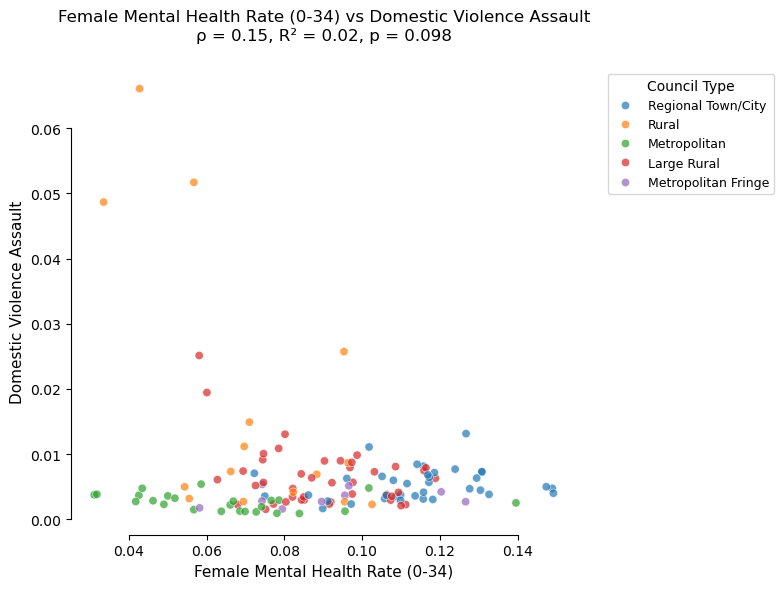

  - Female Mental Health Rate (0-34) vs Domestic Violence Assault: Correlation is not significant (p=0.0979)

Analyzing correlation for Female Mental Health Rate (0-34) and Non-domestic Violence Assault


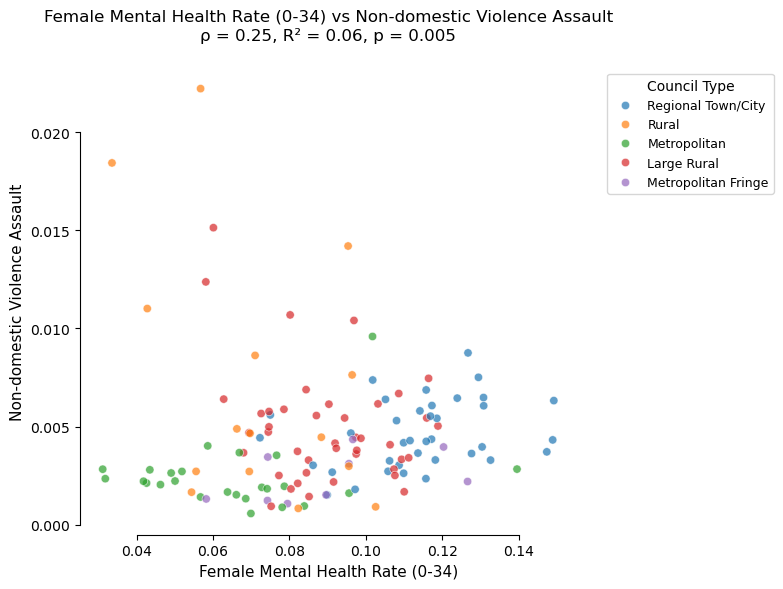

  - Female Mental Health Rate (0-34) vs Non-domestic Violence Assault: Correlation is significant (p=0.0045)

Analyzing correlation for Female Mental Health Rate (0-34) and Assault on Police


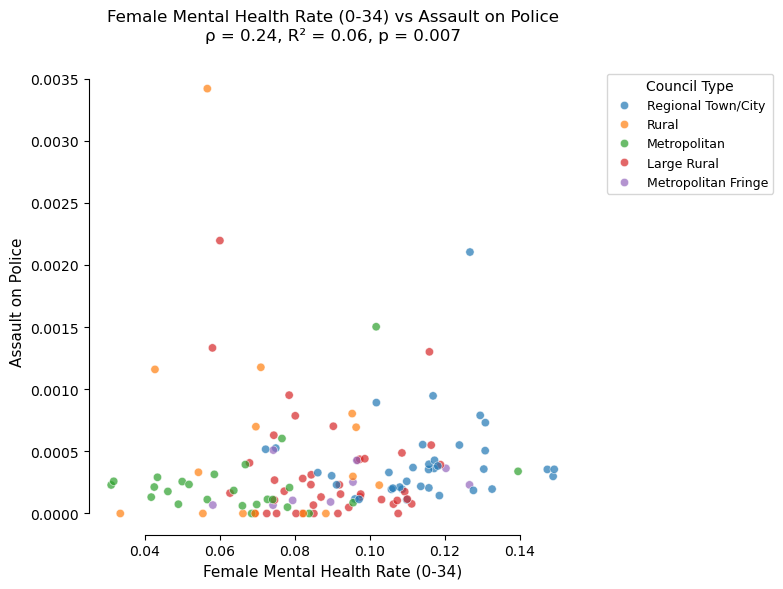

  - Female Mental Health Rate (0-34) vs Assault on Police: Correlation is significant (p=0.0069)

Analyzing correlation for Female Mental Health Rate (0-34) and Sexual Assault


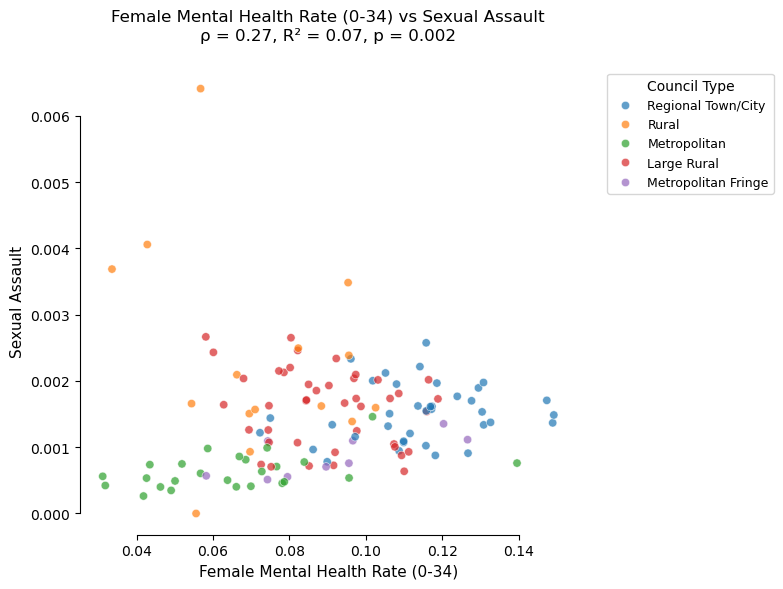

  - Female Mental Health Rate (0-34) vs Sexual Assault: Correlation is significant (p=0.0020)

Analyzing correlation for Female Mental Health Rate (0-34) and Sexual Offences


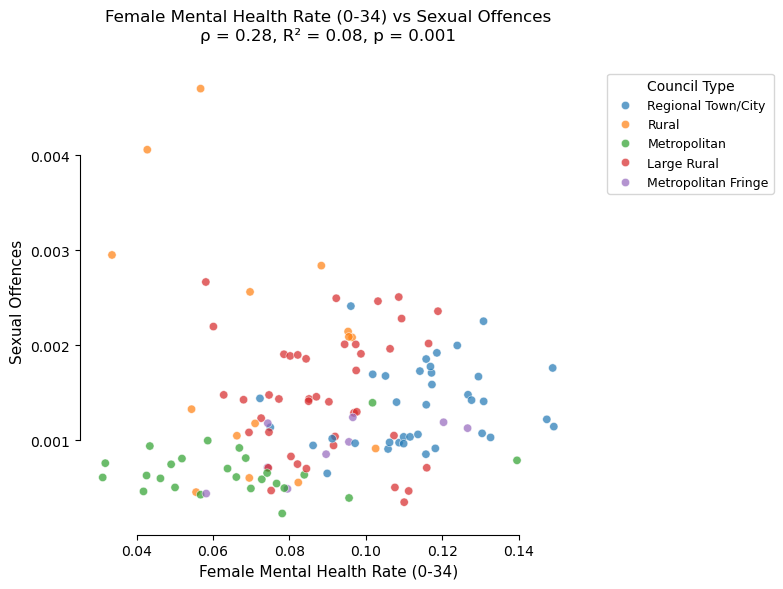

  - Female Mental Health Rate (0-34) vs Sexual Offences: Correlation is significant (p=0.0013)

Analyzing correlation for Female Mental Health Rate (0-34) and Stalking and Harassment


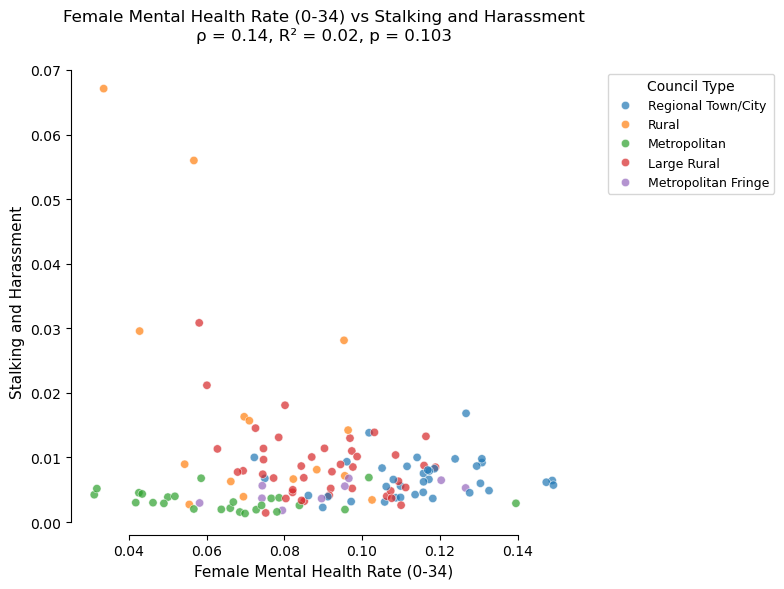

  - Female Mental Health Rate (0-34) vs Stalking and Harassment: Correlation is not significant (p=0.1035)

Analyzing correlation for Female Mental Health Rate (>35) and Domestic Violence Assault


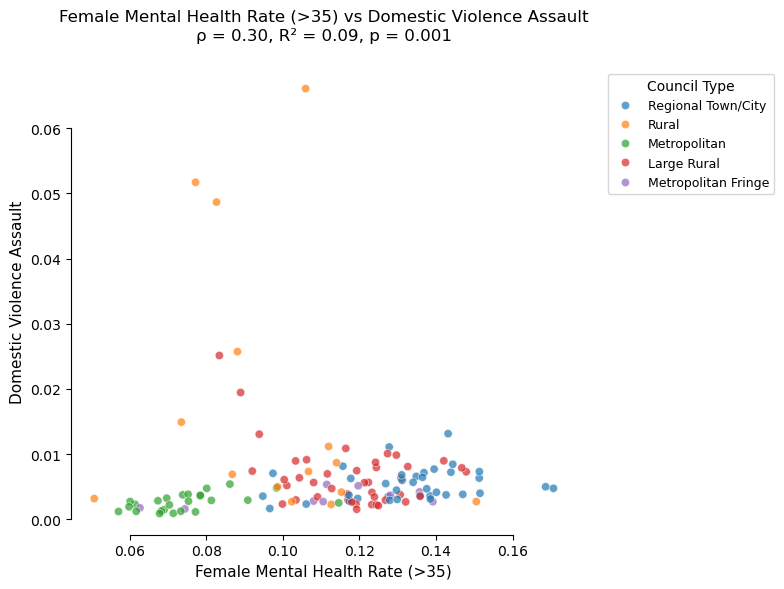

  - Female Mental Health Rate (>35) vs Domestic Violence Assault: Correlation is significant (p=0.0007)

Analyzing correlation for Female Mental Health Rate (>35) and Non-domestic Violence Assault


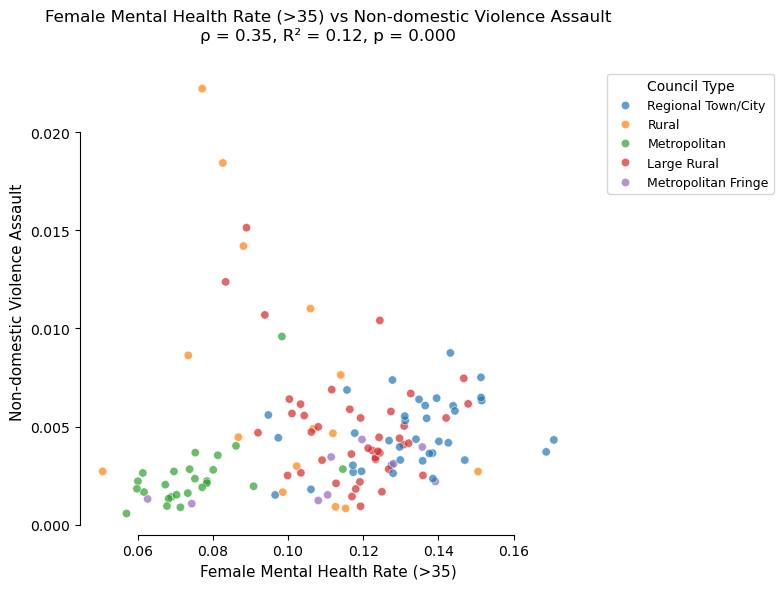

  - Female Mental Health Rate (>35) vs Non-domestic Violence Assault: Correlation is significant (p=0.0001)

Analyzing correlation for Female Mental Health Rate (>35) and Assault on Police


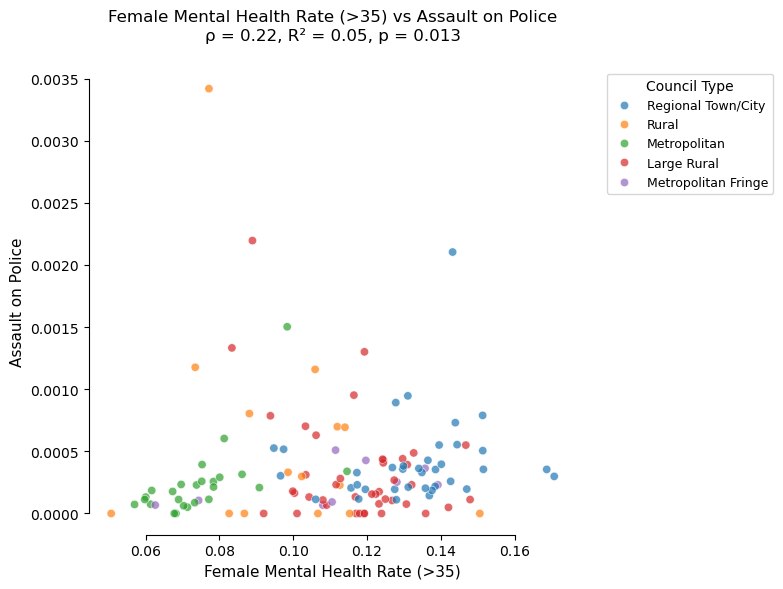

  - Female Mental Health Rate (>35) vs Assault on Police: Correlation is significant (p=0.0134)

Analyzing correlation for Female Mental Health Rate (>35) and Sexual Assault


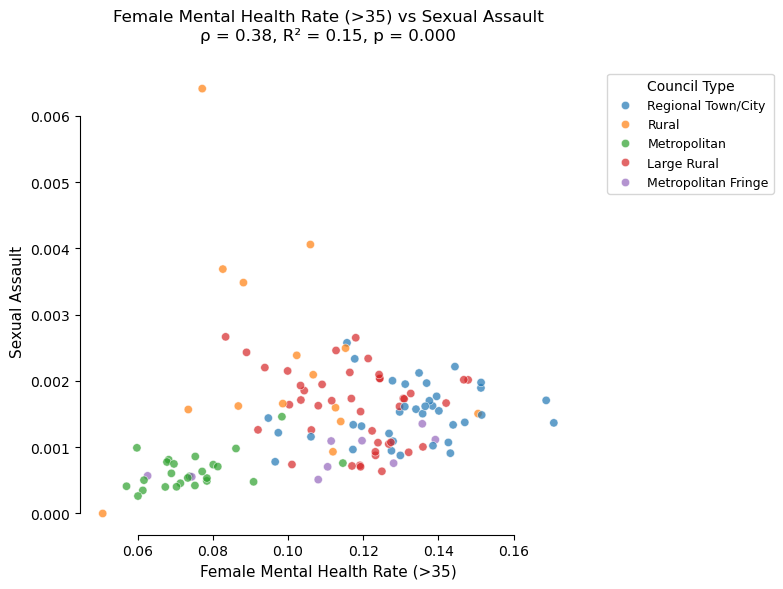

  - Female Mental Health Rate (>35) vs Sexual Assault: Correlation is significant (p=0.0000)

Analyzing correlation for Female Mental Health Rate (>35) and Sexual Offences


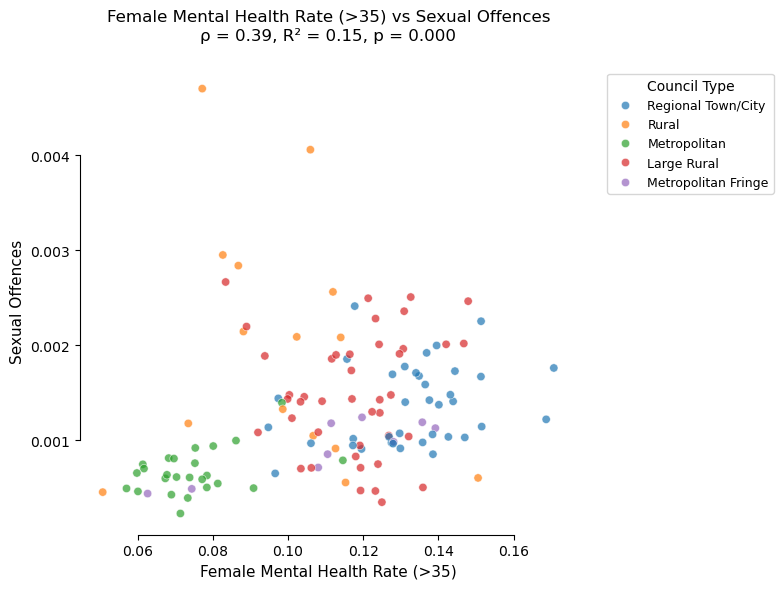

  - Female Mental Health Rate (>35) vs Sexual Offences: Correlation is significant (p=0.0000)

Analyzing correlation for Female Mental Health Rate (>35) and Stalking and Harassment


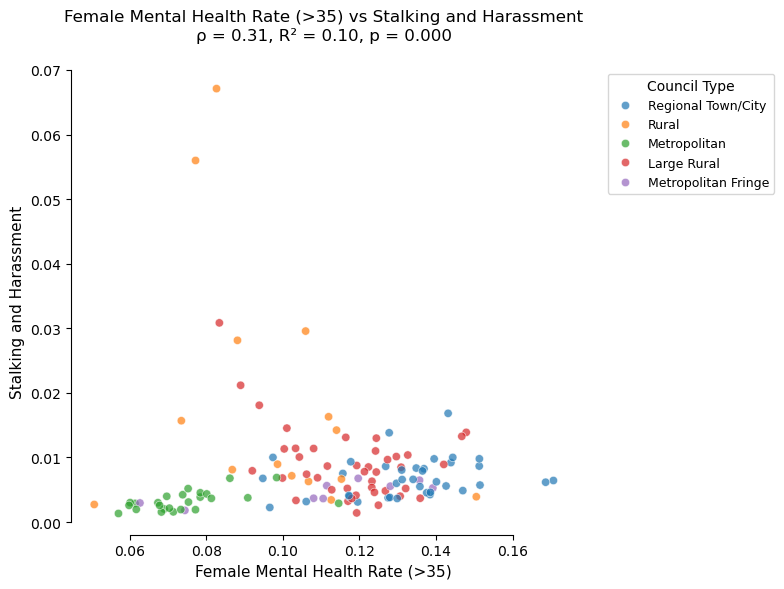

  - Female Mental Health Rate (>35) vs Stalking and Harassment: Correlation is significant (p=0.0004)

Analyzing correlation for Domestic Violence Assault and Non-domestic Violence Assault


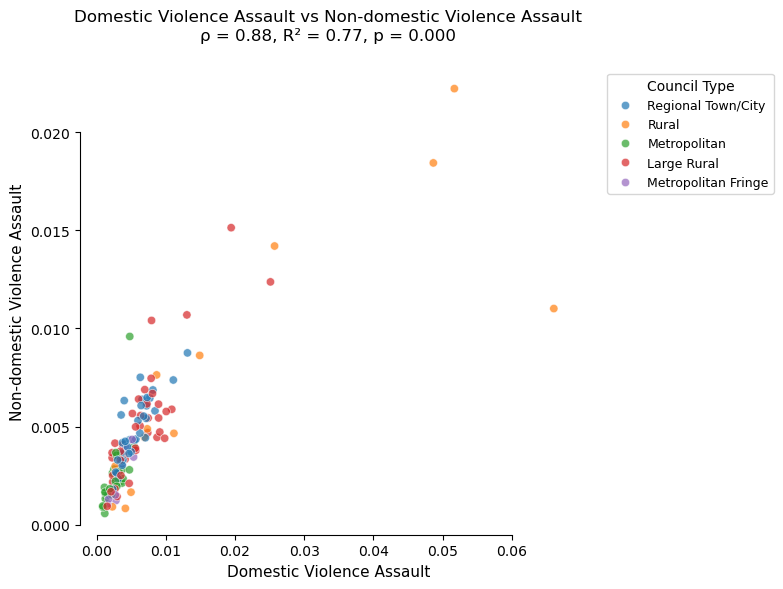

  - Domestic Violence Assault vs Non-domestic Violence Assault: Correlation is significant (p=0.0000)

Analyzing correlation for Domestic Violence Assault and Assault on Police


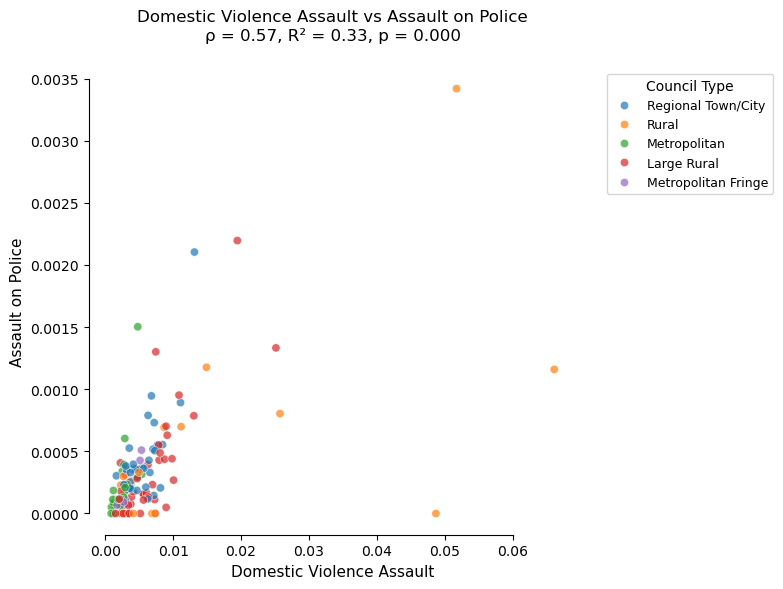

  - Domestic Violence Assault vs Assault on Police: Correlation is significant (p=0.0000)

Analyzing correlation for Domestic Violence Assault and Sexual Assault


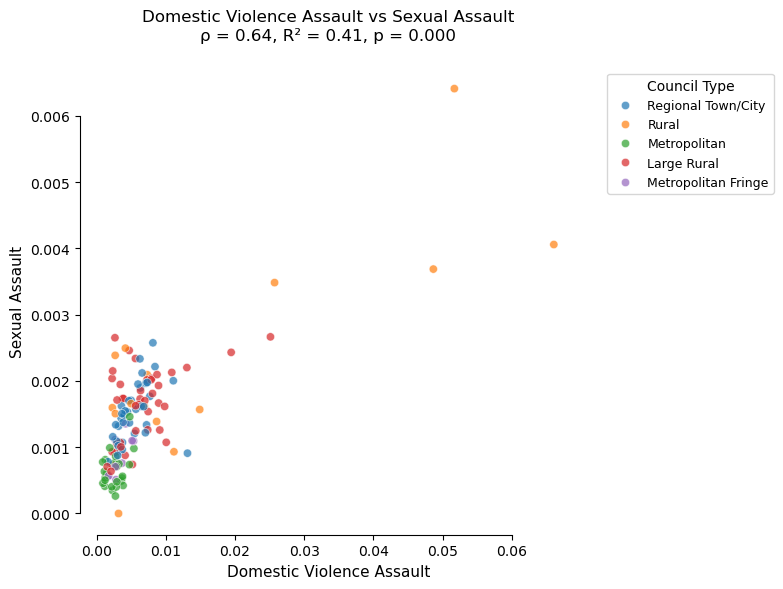

  - Domestic Violence Assault vs Sexual Assault: Correlation is significant (p=0.0000)

Analyzing correlation for Domestic Violence Assault and Sexual Offences


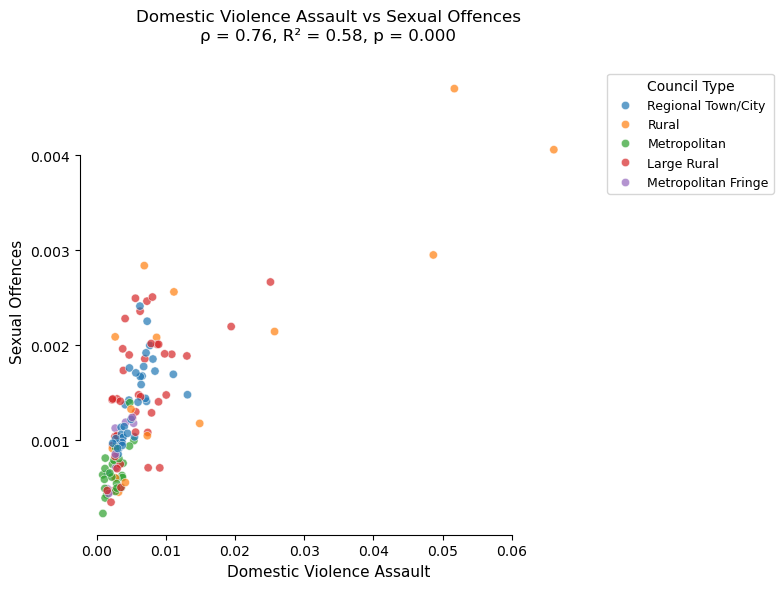

  - Domestic Violence Assault vs Sexual Offences: Correlation is significant (p=0.0000)

Analyzing correlation for Domestic Violence Assault and Stalking and Harassment


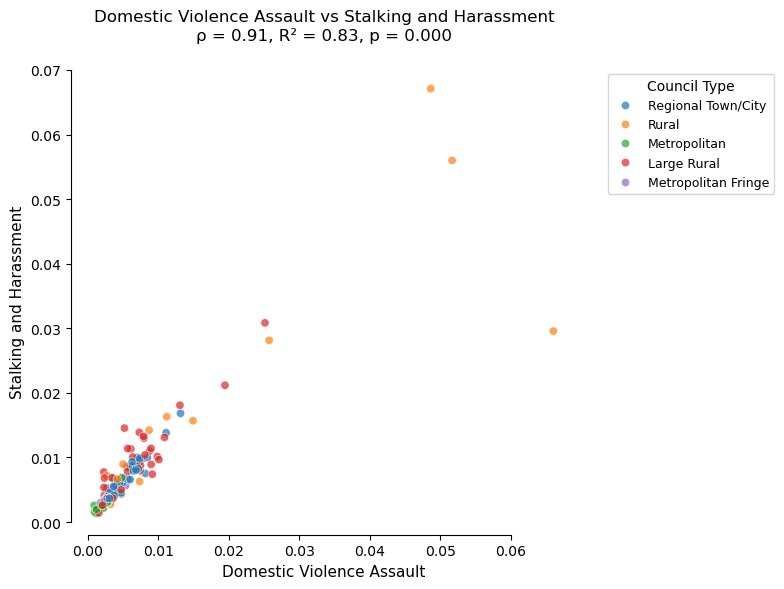

  - Domestic Violence Assault vs Stalking and Harassment: Correlation is significant (p=0.0000)

Analyzing correlation for Non-domestic Violence Assault and Assault on Police


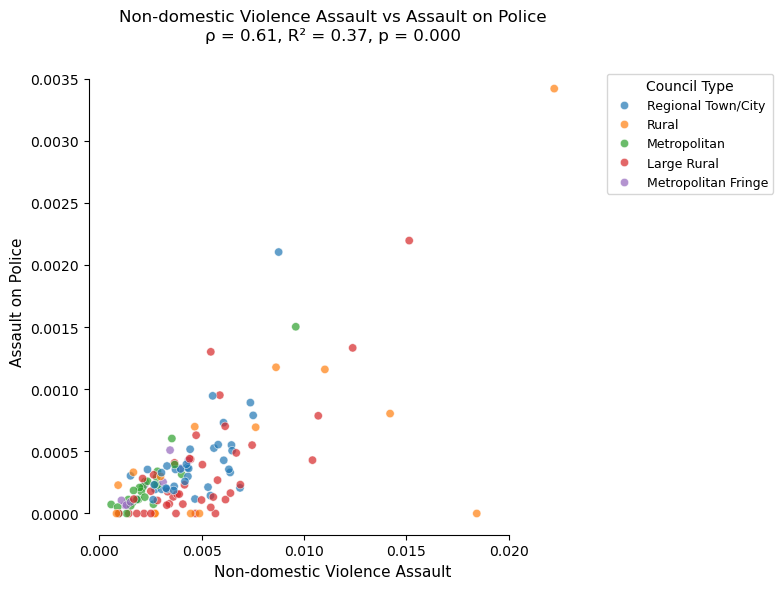

  - Non-domestic Violence Assault vs Assault on Police: Correlation is significant (p=0.0000)

Analyzing correlation for Non-domestic Violence Assault and Sexual Assault


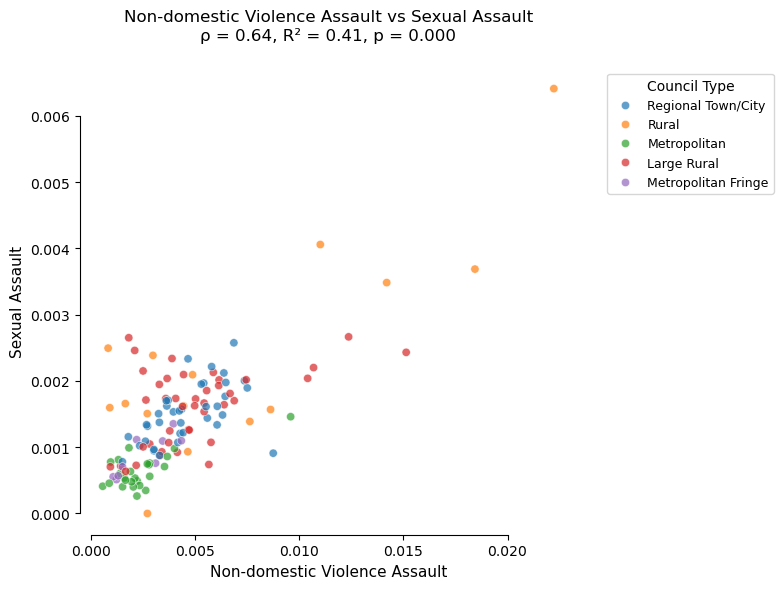

  - Non-domestic Violence Assault vs Sexual Assault: Correlation is significant (p=0.0000)

Analyzing correlation for Non-domestic Violence Assault and Sexual Offences


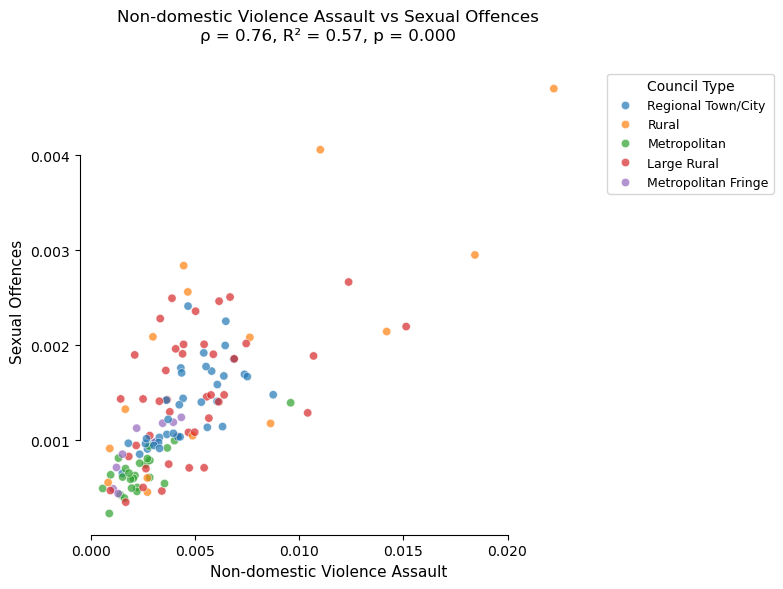

  - Non-domestic Violence Assault vs Sexual Offences: Correlation is significant (p=0.0000)

Analyzing correlation for Non-domestic Violence Assault and Stalking and Harassment


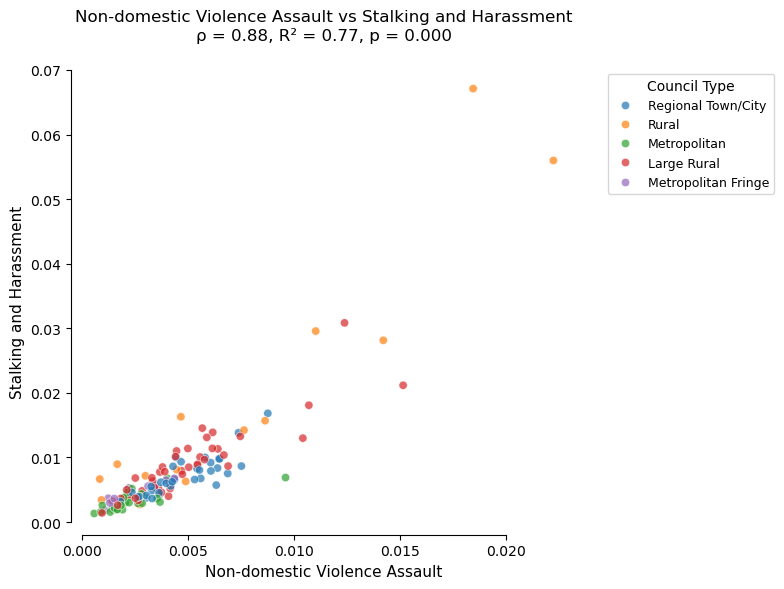

  - Non-domestic Violence Assault vs Stalking and Harassment: Correlation is significant (p=0.0000)

Analyzing correlation for Assault on Police and Sexual Assault


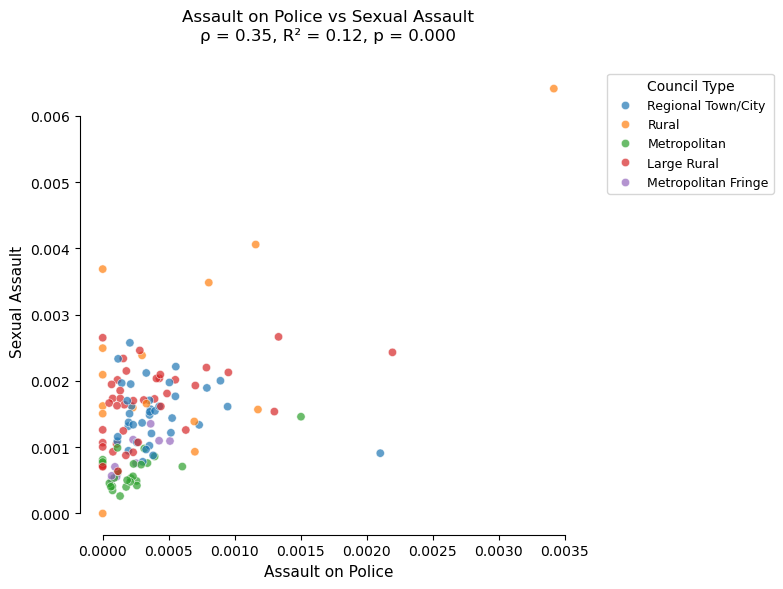

  - Assault on Police vs Sexual Assault: Correlation is significant (p=0.0001)

Analyzing correlation for Assault on Police and Sexual Offences


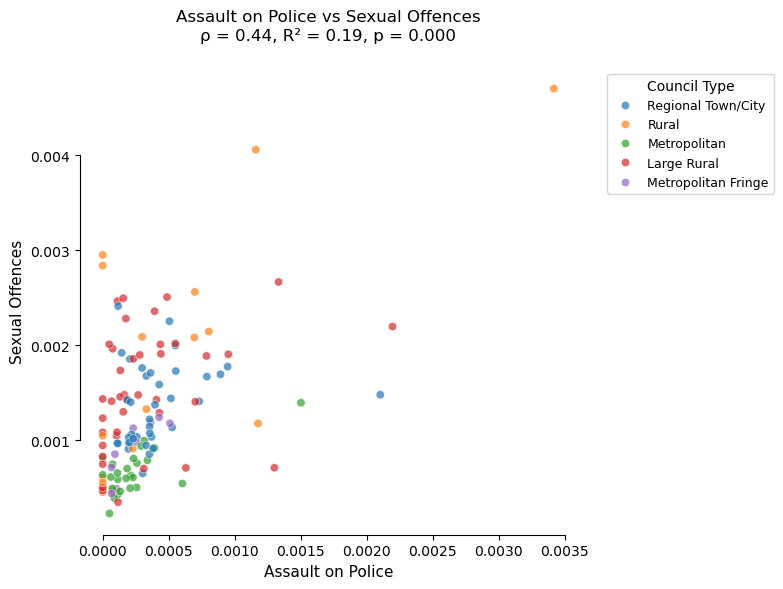

  - Assault on Police vs Sexual Offences: Correlation is significant (p=0.0000)

Analyzing correlation for Assault on Police and Stalking and Harassment


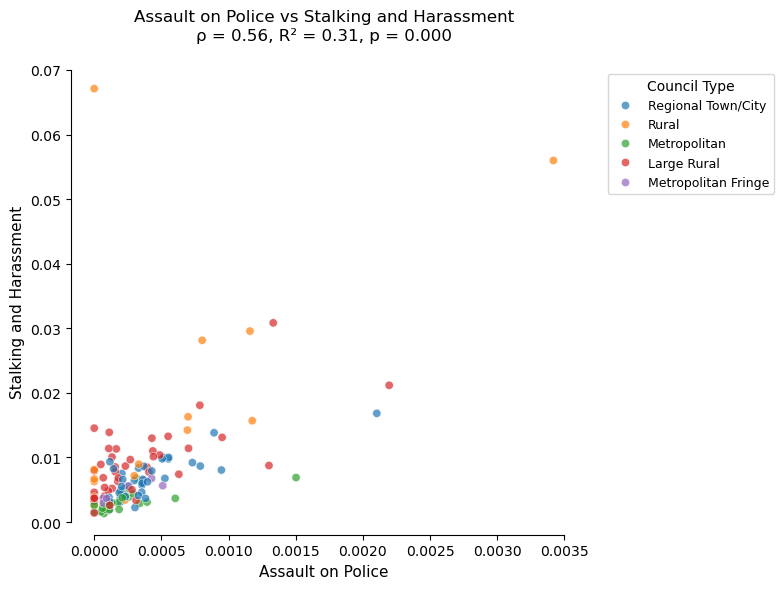

  - Assault on Police vs Stalking and Harassment: Correlation is significant (p=0.0000)

Analyzing correlation for Sexual Assault and Sexual Offences


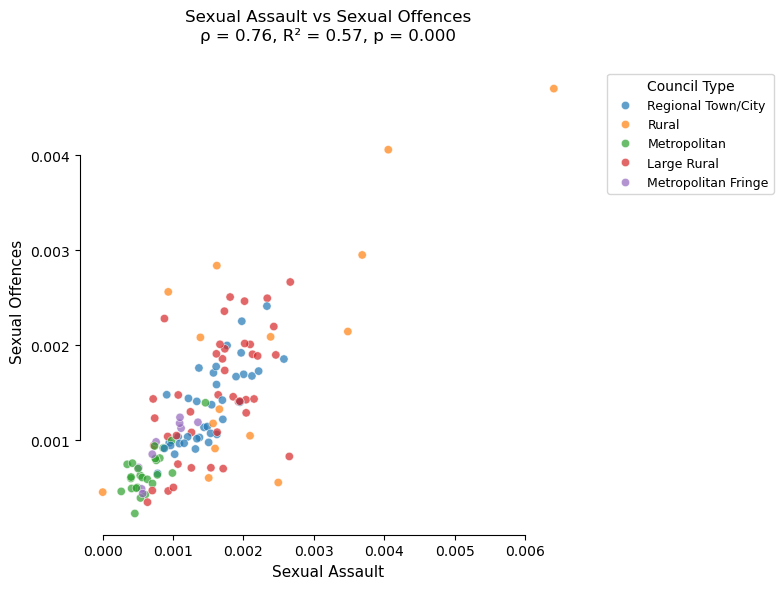

  - Sexual Assault vs Sexual Offences: Correlation is significant (p=0.0000)

Analyzing correlation for Sexual Assault and Stalking and Harassment


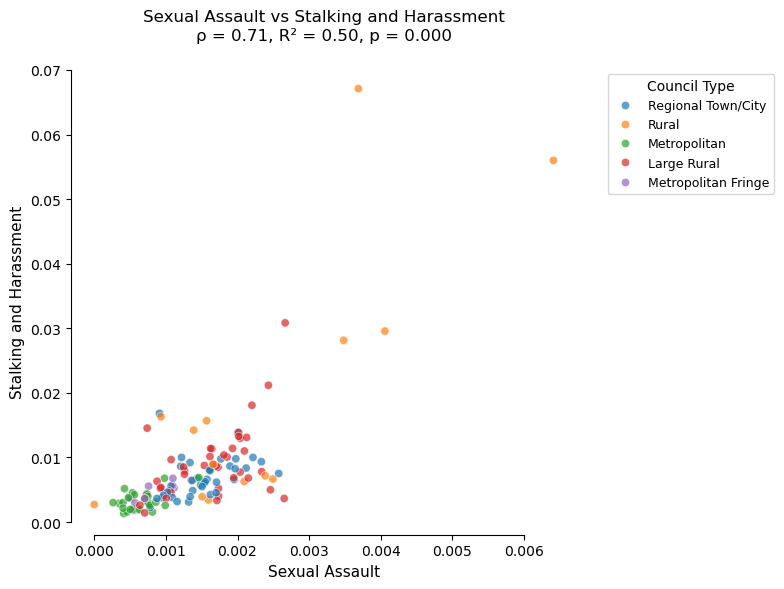

  - Sexual Assault vs Stalking and Harassment: Correlation is significant (p=0.0000)

Analyzing correlation for Sexual Offences and Stalking and Harassment


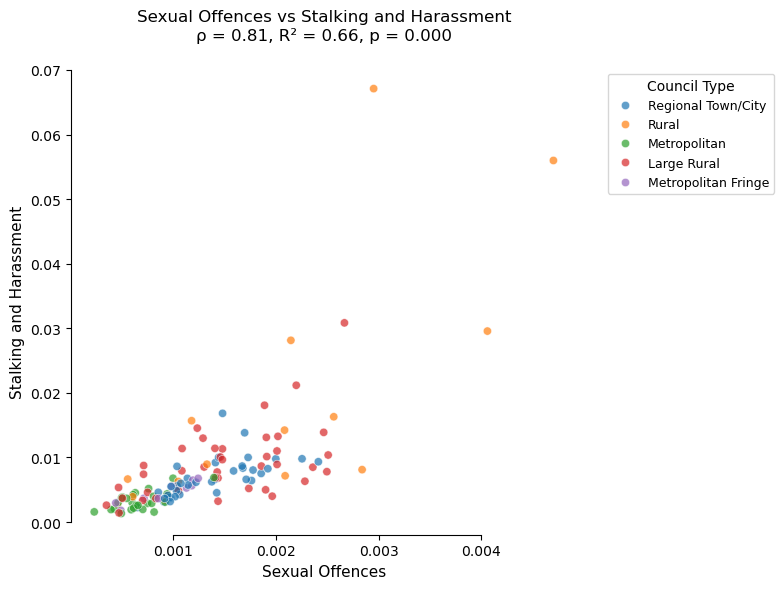

  - Sexual Offences vs Stalking and Harassment: Correlation is significant (p=0.0000)


In [49]:

# Define the variables as their raw names (this is what the actual dataframe uses)
variables = [
    'Socio-economic Disadvantage',
    'Socio-economic Advantage/Disadvantage',
    'Economic Resources',
    'Education and Occupation',
    'Male Mental Health Rate (0-34)',
    'Male Mental Health Rate (>35)',
    'Female Mental Health Rate (0-34)',
    'Female Mental Health Rate (>35)',
    'Domestic Violence Assault',
    'Non-domestic Violence Assault',
    'Assault on Police',
    'Sexual Assault',
    'Sexual Offences',
    'Stalking and Harassment'
]

def calculate_correlation(var1, var2, data):
    # Remove NaN values
    data_clean = data[[var1, var2]].dropna()
    # Normality assumption failed: Use Spearman's rank correlation
    corr, p_value = spearmanr(data_clean[var1], data_clean[var2])
    r_squared = corr ** 2  # Calculate R²
    
    # Create figure with APA-style formatting
    fig, ax = plt.subplots(figsize=(8, 6))

    # Create the scatter plot
    sns.scatterplot(data=data, x=var1, y=var2, hue='Council Type', 
                   ax=ax, alpha=0.7)  # Added slight transparency
    
    # Format title and labels according to APA style
    ax.set_title(f'{var1} vs {var2}\n'
                 f'ρ = {corr:.2f}, R² = {r_squared:.2f}, p = {p_value:.3f}',
                pad=20, fontsize=12)
    
    # Adjust axes labels with APA font size
    ax.set_xlabel(var1, fontsize=11)
    ax.set_ylabel(var2, fontsize=11)
    
    # Format legend
    ax.legend(title='Council Type', title_fontsize=10, fontsize=9,
             bbox_to_anchor=(1.05, 1), loc='upper left')
    
    # Add spines
    sns.despine(trim=True)  # Removes top and right spines
    
    # Adjust layout to prevent label cutoff
    plt.tight_layout()
    
    # Show plot
    plt.show()
    
    return corr, p_value

# Plot scatterplots for each pair of variables separated by 'Council Type'
for i, var1 in enumerate(variables):
    for var2 in variables[i+1:]:
        # Check if the variables have enough data points (e.g., no empty columns)
        if df_crime_health_seifa_council[var1].isnull().sum() == 0 and df_crime_health_seifa_council[var2].isnull().sum() == 0:
            print(f"\nAnalyzing correlation for {var1} and {var2}")

            # Calculate the correlation and display results
            corr, p_value = calculate_correlation(var1, var2, df_crime_health_seifa_council)

            # If correlation value is significant, display further information
            if p_value < 0.05:
                print(f"  - {var1} vs {var2}: Correlation is significant (p={p_value:.4f})")
            else:
                print(f"  - {var1} vs {var2}: Correlation is not significant (p={p_value:.4f})")
        else:
            print(f"  - Skipping {var1} vs {var2} due to missing data.")
